In [1]:
import os

import bilby
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats

import dill
from tqdm import tqdm

import util

# Helper Functions

In [2]:
dphi = ["d_phi_0", "d_phi_1", "d_phi_2", "d_phi_3", "d_phi_4", "d_phi_5L", "d_phi_6", "d_phi_6L", "d_phi_7"]
dalpha = ["d_alpha_2", "d_alpha_3", "d_alpha_4"]
dbeta = ["d_beta_2", "d_beta_3"]

dpi = dphi + dalpha + dbeta

In [3]:
def load_hybrid_data(rundir, result_prefix, dpi, extra_label=None):
    resultdir = os.path.join(rundir, "result")

    if extra_label is None:
        result_path = os.path.join(resultdir, "%s_%s_result.json" % (result_prefix, dpi))
        resume_path = os.path.join(resultdir, "%s_%s_checkpoint_resume.pickle" % (result_prefix, dpi))
    else:
        result_path = os.path.join(resultdir, "%s_%s_%s_result.json" % (result_prefix, dpi, extra_label))
        resume_path = os.path.join(resultdir, "%s_%s_%s_checkpoint_resume.pickle" % (result_prefix, dpi, extra_label))
    
    result = bilby.core.result.read_in_result(result_path) if os.path.isfile(result_path) else None
    
    with open(resume_path, 'rb') as f:
        resume = dill.load(f)
        
    return result, resume

In [4]:
def load_nest_data(rundir, result_prefix):
    result_path = os.path.join(
        rundir, "result",
        "%s_result.json" % result_prefix
    )

    result = bilby.core.result.read_in_result(result_path) if os.path.isfile(result_path) else None
    return result

In [9]:
def plot_evolution(nest_result, hybrid_result, hybrid_resume, xparam, yparam, xlabel, ylabel, xtrue, ytrue, title, iterations = None, plot_kde=True, dark_mode=False):
    true_value_line_color = "black"
    
    if dark_mode == True:
        plt.style.use('dark_background')
        true_value_line_color = "white"
    
    xidx = hybrid_result.search_parameter_keys.index(xparam)
    y_hybrid_idx = hybrid_result.search_parameter_keys.index(yparam)
    y_nest_idx = nest_result.search_parameter_keys.index(yparam)
    
    nwalkers = hybrid_result.sampler_kwargs["nwalkers"]
    nhybrid, _ = hybrid_result.samples.shape
    nnest, _ = nest_result.samples.shape
    
    nrows, ncols = (3,4)
    fig, axes = plt.subplots(figsize=(12,8), dpi=300, nrows=nrows, ncols=ncols, sharex="col", sharey="row")
    fig.supxlabel(xlabel, fontsize=15)
    fig.supylabel(ylabel, fontsize=15)
    fig.suptitle(title, fontsize=15)

    if iterations is None:
        iterations = np.array([0,2,16,128,1024,2048])
    
    interior_axes = [
           axes[i,j] for i in range(1,nrows) for j in range(1,ncols)
    ]
    
    top_hists = [ axes[0,j] for j in range(1,ncols) ]
    left_hists = [ axes[i,0] for i in range(1,nrows) ] 
    
    for ax in interior_axes:
        ax.get_shared_x_axes().join(ax, *interior_axes)
        ax.get_shared_y_axes().join(ax, *interior_axes)
        
        ax.get_shared_x_axes().join(ax, *top_hists)
        ax.get_shared_y_axes().join(ax, *left_hists)
    
    axes[0,0].axis('off')
    
    nest_color = "#4895ef" #mpl.cm.get_cmap('Blues')(0.6) #"#e0bbc9"
    hybrid_colors = np.array(["#f72585"] + [ "#B450F7", "#9B15F4", "#7D19F0", "#6210E5", "#3a0ca3" ], dtype="object")
        
    hybrid_chain = hybrid_resume["chain_array"]
    
    ### top hists ###  
    for k,ax in enumerate(top_hists):
        for color,it in zip(hybrid_colors[k::nrows],iterations[k::nrows]):
            xdata = hybrid_chain[:,it,xidx]
            ax.hist(xdata, density=True, color=color, histtype="step", zorder=0)
            
        ax.axvline(x=xtrue, linestyle="--", color=true_value_line_color, zorder=-1)
            
    ### left hists ###
    for k,ax in enumerate(left_hists):
        if k == 0:
            ax.hist(
                nest_result.samples[:,y_nest_idx], 
                density=True, color=nest_color, histtype="step", orientation="horizontal",
                zorder=1
            )

        
        for color,it in zip(hybrid_colors[k*(ncols-1):(k+1)*(ncols-1)],iterations[k*(ncols-1):(k+1)*(ncols-1)]):
            ydata = hybrid_chain[:,it,y_hybrid_idx]
            ax.hist(ydata, density=True, color=color, histtype="step", orientation="horizontal", zorder=0)
            
        ax.axhline(y=ytrue, linestyle="--", color=true_value_line_color, zorder=-1)
        
        if k == len(left_hists)-1:
            ax.set_xlim( ax.get_xlim()[::-1] )

    
    ### interior plots ###
    for k,(color,it,ax) in enumerate(zip(hybrid_colors,iterations,interior_axes)):
        xdata = hybrid_chain[:,it,xidx]
        ydata = hybrid_chain[:,it,y_hybrid_idx]
        
        ax.axvline(x=xtrue, linestyle="--", color=true_value_line_color, zorder=-1)
        ax.axhline(y=ytrue, linestyle="--", color=true_value_line_color, zorder=-1)
        
        if k == 0:
            ax.scatter(
                np.zeros(nnest), nest_result.samples[:,y_nest_idx],
                s=2,
                c=nest_color,
                zorder=1
            )

            ax.scatter(
                xdata, ydata,
                s=2,
                c=color,
                zorder=0
            )

            ax.set_title("Initialization")
        else:
            if plot_kde:
                x = hybrid_chain[:, :it, xidx].flatten()
                y = hybrid_chain[:, :it, y_hybrid_idx].flatten()
                X, Y = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
                positions = np.vstack([X.ravel(), Y.ravel()])
                values = np.vstack([x, y])
                kernel = scipy.stats.gaussian_kde(values)
                Z = np.reshape(kernel(positions).T, X.shape) 

                ax.contour(X, Y, Z, cmap=plt.cm.Greys, zorder=2, levels=3)

            ax.scatter(
                xdata, ydata,
                s=2, c=color,
                zorder=1,
            )

            ax.set_title("Step %d" % it )
            
    axes[-1,0].set_xticklabels([])
    return fig, axes

# Injected Signals

## High SNR

In [5]:
highsnr_rundir = "/home/noah.wolfe/MA499_report_runs/injected/beyond-gr/SNR/beyond-gr_d_phi_2-2E-01_dL-100/beyond-gr_d_phi_2-2E-01_dL-100_hybrid"
highsnr_hybrid_result, highsnr_hybrid_resume = load_hybrid_data(
    highsnr_rundir, 
    "beyond-gr_d_phi_2-2E-01_dL-100_hybrid_data0_0-0_analysis_H1L1_dynesty",
    "d_phi_2"
)

In [6]:
highsnr_nest_result = load_nest_data(
    highsnr_rundir, 
    "beyond-gr_d_phi_2-2E-01_dL-100_hybrid_data0_0-0_analysis_H1L1_dynesty",
)

In [7]:
highsnr_hybrid_resume["chain_array"].shape

(250, 2500, 14)

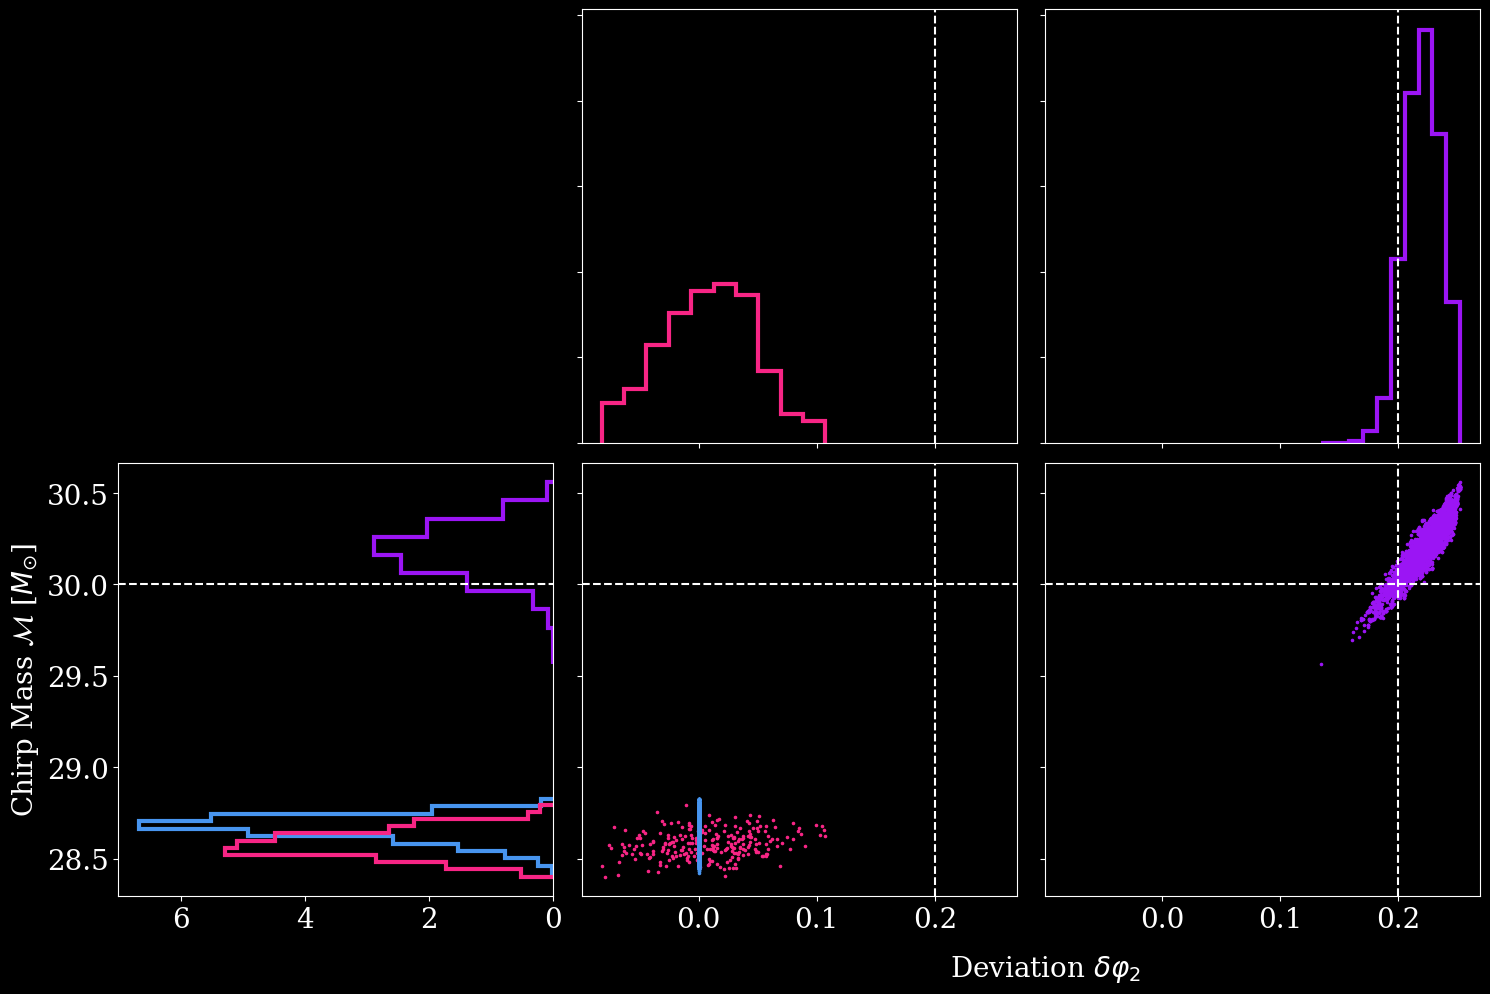

In [50]:
plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=3, dpi=100, sharex="col", sharey="row")

mass_nest_idx = highsnr_nest_result.search_parameter_keys.index("chirp_mass")
mass_idx = highsnr_hybrid_result.search_parameter_keys.index("chirp_mass")
dphi_idx = highsnr_hybrid_result.search_parameter_keys.index("d_phi_2")

nest_mass = highsnr_nest_result.samples[:,mass_nest_idx]

init_mass = highsnr_hybrid_resume["chain_array"][:,0,mass_idx]
init_dphi = highsnr_hybrid_resume["chain_array"][:,0,dphi_idx]

final_mass = highsnr_hybrid_resume["chain_array"][:,1960:2000,mass_idx].flatten()
final_dphi = highsnr_hybrid_resume["chain_array"][:,1960:2000,dphi_idx].flatten()

### scatter
# plot dynesty posterior, initialize prior
axes[1,1].scatter(
    init_dphi,
    init_mass,
    color="#f72585",
    s=2.5
)

axes[1,1].scatter(
    np.zeros( highsnr_nest_result.samples.shape[0] ),
    nest_mass,
    color="#4895ef",
    s=2.5
)

axes[1,1].axvline( x=0.2, linestyle="--", color="white" )
axes[1,1].axhline( y=30, linestyle="--", color="white" )

# make scatter plot panels shared their x-axis
axes[1,1].get_shared_x_axes().join( axes[1,1], axes[1,2] )


# plot final result... maybe the whole posterior?
axes[1,2].scatter(
    final_dphi,
    final_mass,
    color="#9B15F4",
    s=2.5
) 
axes[1,2].axvline( x=0.2, linestyle="--", color="white" )
axes[1,2].axhline( y=30, linestyle="--", color="white" )


### histograms
# mass
axes[1,0].hist( nest_mass, density=True, color="#4895ef", histtype="step", orientation="horizontal", zorder=0, linewidth=3, label=r"Fast Result for $\theta_{\mathrm{GR}$" )
axes[1,0].hist( init_mass, density=True, color="#f72585", histtype="step", orientation="horizontal", zorder=1, linewidth=3, label=r"Initialization" )
axes[1,0].hist( final_mass, density=True, color="#9B15F4", histtype="step", orientation="horizontal", zorder=1, linewidth=3, label=r"Hybrid Result" )
axes[1,0].set_xlim( axes[1,0].get_xlim()[::-1] )
axes[1,0].axhline(y=30, linestyle="--", color="white")


# dphi
axes[0,1].hist( init_dphi, density=True, color="#f72585", histtype="step", zorder=1, linewidth=3 )
axes[0,2].hist( final_dphi, density=True, color="#9B15F4", histtype="step", zorder=1, linewidth=3 )

axes[0,1].axvline( x=0.2, linestyle="--", color="white" )
axes[0,2].axvline( x=0.2, linestyle="--", color="white" )

### labeling!
for ax in axes.flat:
    ax.tick_params(labelsize=20)

axes[1,0].set_ylabel(r"Chirp Mass $\mathcal{M}$ [$M_{\odot}$]", fontsize=20)
fig.supxlabel(r"Deviation $\delta \varphi_2$", fontsize=20, x=0.7)

### turn off errant axis
axes[0,0].axis('off')

### add a big legend
fig.legend(

)

plt.tight_layout()

In [13]:
highsnr_nest_result.samples.shape

(28887, 13)

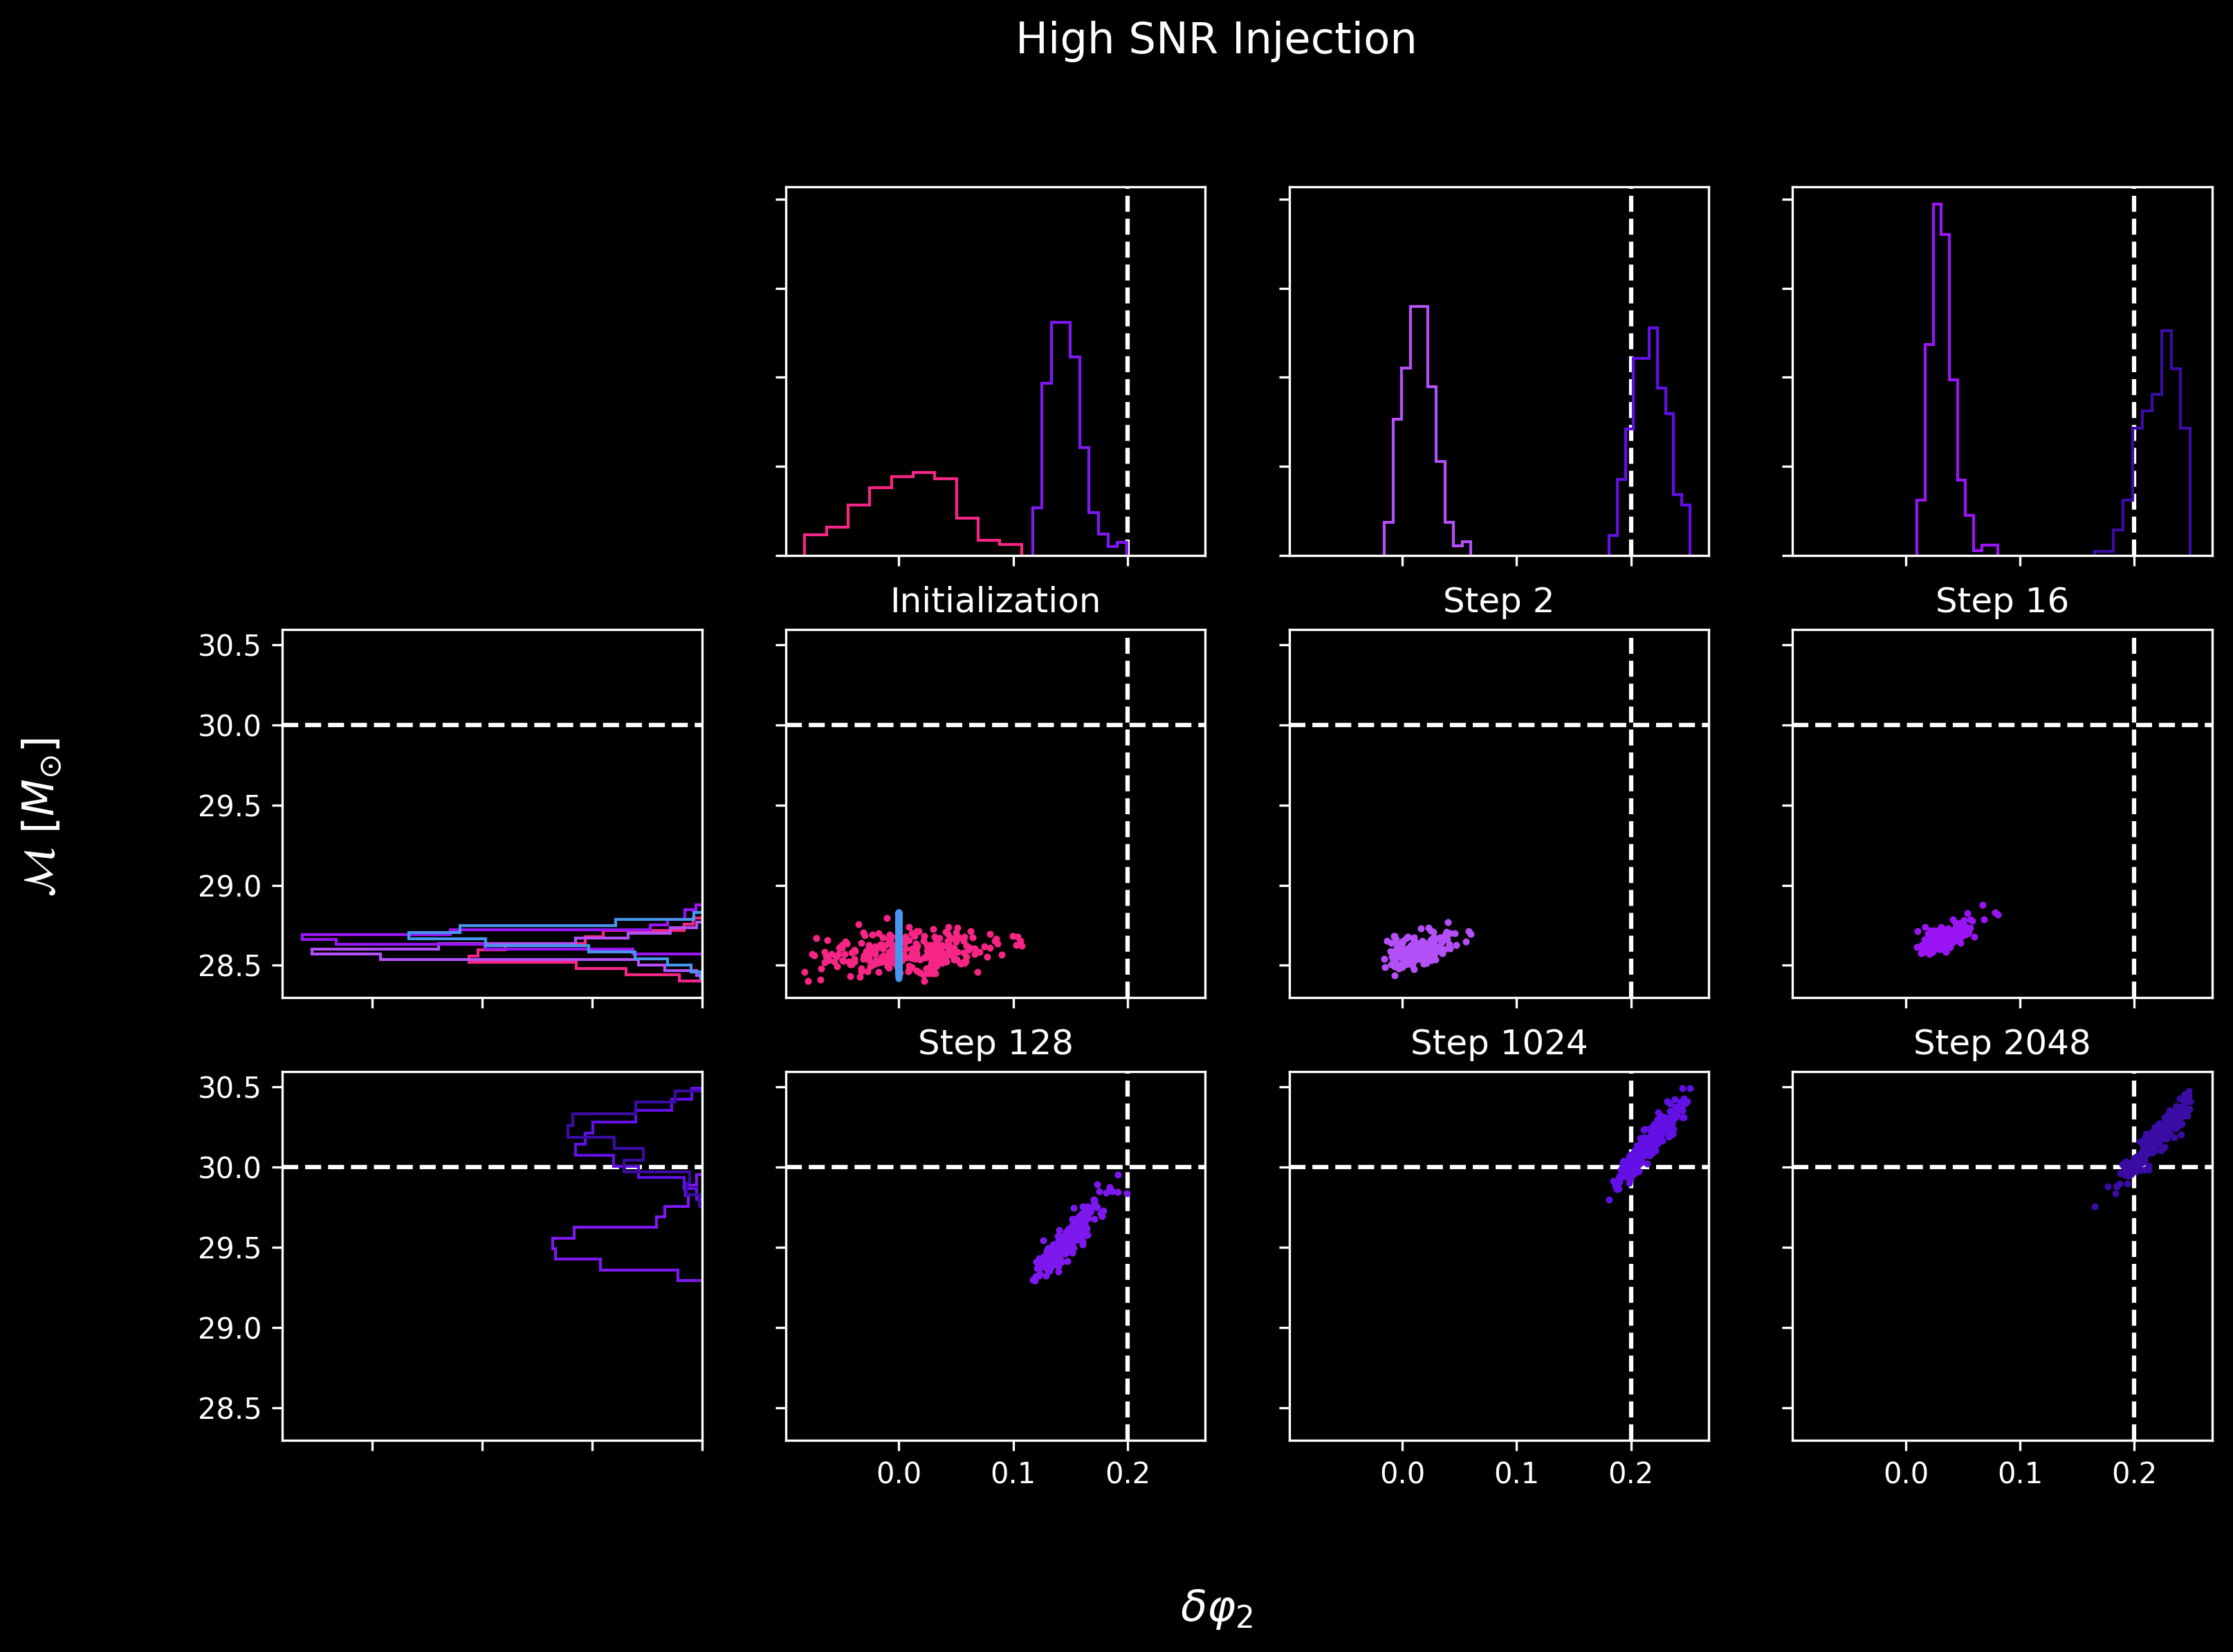

In [10]:
fig_hig, axes_high = plot_evolution(
    highsnr_nest_result, highsnr_hybrid_result, highsnr_hybrid_resume, 
    "d_phi_2", "chirp_mass", r"$\delta \varphi_2$", "$\mathcal{M}$ [$M_{\odot}$]", 0.2, 30, 
    "High SNR Injection", plot_kde=False, dark_mode=True
)

## Low SNR

In [12]:
lowsnr_rundir = "/home/noah.wolfe/MA499_report_runs/injected/beyond-gr/SNR/beyond-gr_d_phi_2-2E-01_dL-1000/beyond-gr_d_phi_2-2E-01_dL-1000_hybrid"
lowsnr_hybrid_result, lowsnr_hybrid_resume = load_hybrid_data(
    lowsnr_rundir, 
    "beyond-gr_d_phi_2-2E-01_dL-1000_hybrid_data0_0-0_analysis_H1L1_dynesty",
    "d_phi_2"
)

In [13]:
lowsnr_nest_result = load_nest_data(
    lowsnr_rundir, 
    "beyond-gr_d_phi_2-2E-01_dL-1000_hybrid_data0_0-0_analysis_H1L1_dynesty",
)

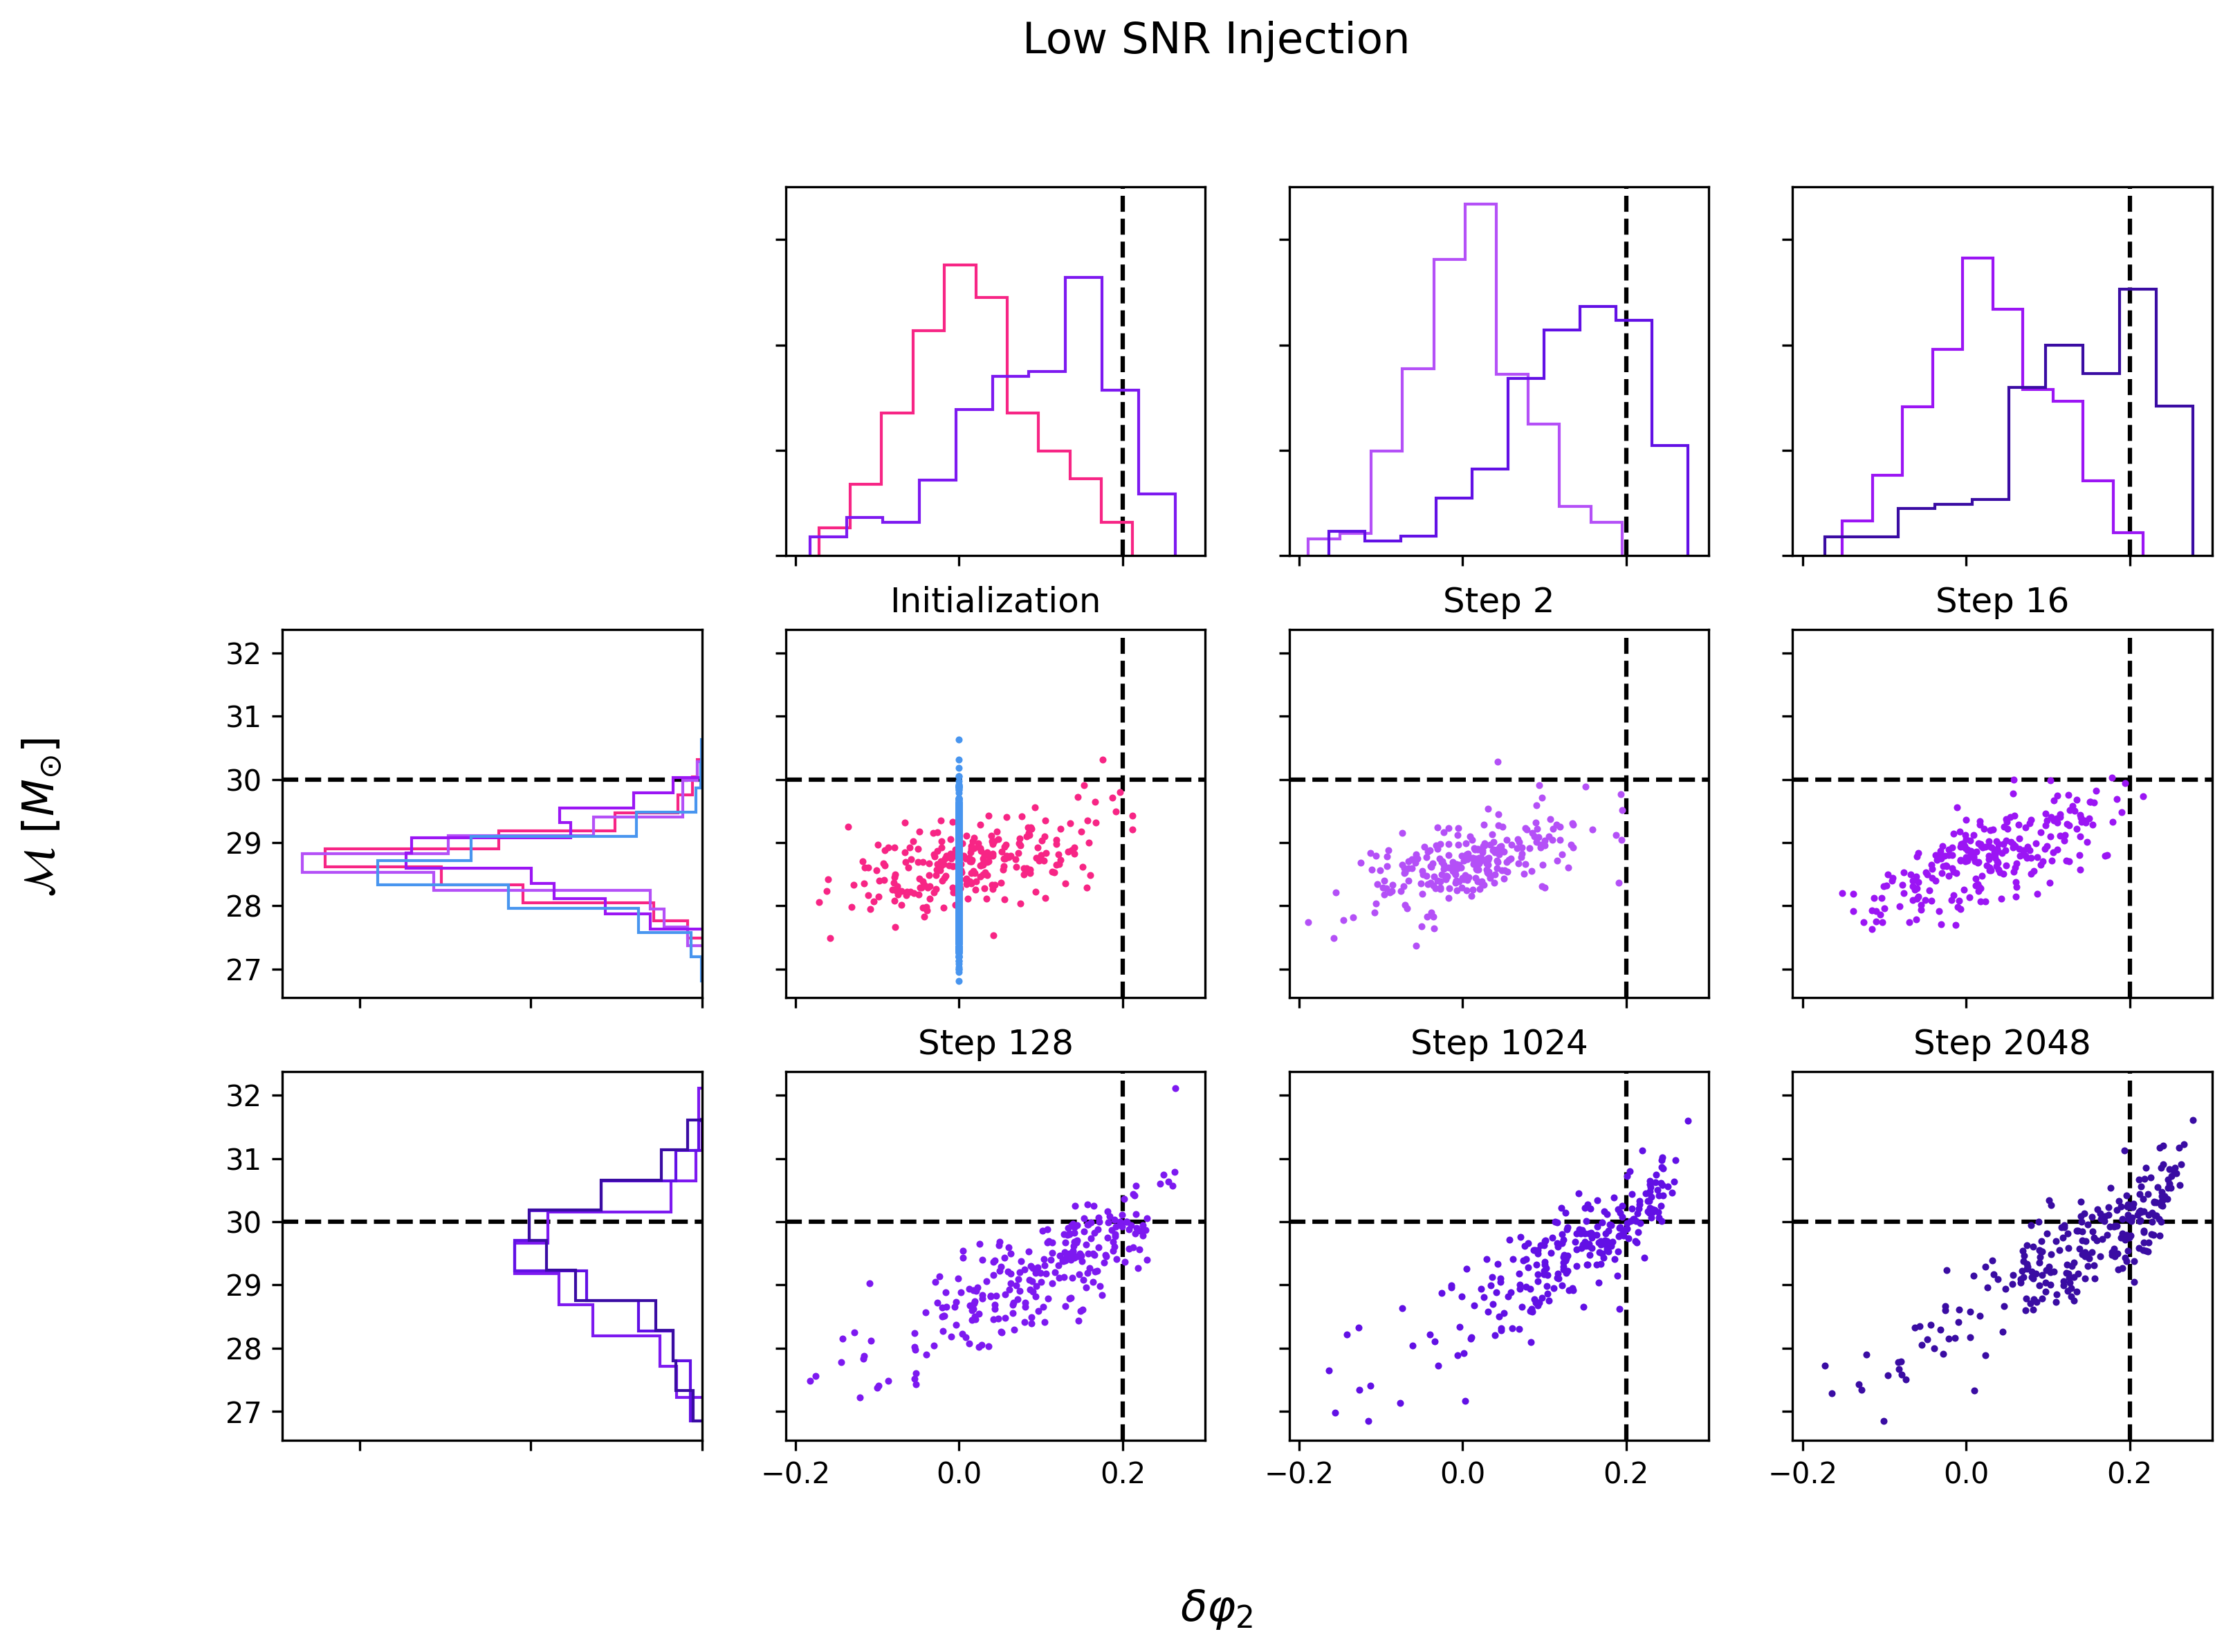

In [16]:
fig_low, axes_low = plot_evolution(
    lowsnr_nest_result, lowsnr_hybrid_result, lowsnr_hybrid_resume, 
    "d_phi_2", "chirp_mass", r"$\delta \varphi_2$", "$\mathcal{M}$ [$M_{\odot}$]", 0.2, 30, 
    "Low SNR Injection", plot_kde=False
)

### Test w/ overlap stuff

In [134]:
import bilby
import bilby_tgr

duration = 2.
sampling_frequency = 1024.

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2',
    reference_frequency=50., 
    minimum_frequency=20.,
    min_match=0.9,
    return_match=True
 )

# Create the waveform_generator using our beyond-GR source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby_tgr.source.generic_non_gr_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments
)


10:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby_tgr.source.generic_non_gr_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [163]:
import copy
nm = 100
nd = 100

xs, ys = [], []

for n in tqdm(range(50)):
    inject = copy.deepcopy(lowsnr_hybrid_result.injection_parameters)
    for i,k in enumerate(lowsnr_hybrid_result.search_parameter_keys):
        inject[k] = lowsnr_hybrid_resume["chain_array"][n,2048,i]
        
    n_xs = []
    n_ys = []
        
    #print(inject)
        
    for d, m in zip( np.linspace(-0.3,0.3,nd), np.linspace(27,31,nm) ):
        x_inject = copy.deepcopy(inject)
        x_inject["chirp_mass"] = m
        x_inject["d_phi_2"]    = d
        
        _, complex_overlap = waveform_generator.frequency_domain_strain(parameters=x_inject)
        overlap = np.abs(complex_overlap)
        if overlap <= 0.9:
            n_xs.append(d)
            n_ys.append(m)
            
    xs.append(n_xs)
    ys.append(n_ys)

  0%|          | 0/50 [00:00<?, ?it/s]/home/noah.wolfe/.conda/envs/testing-gr/lib/python3.8/site-packages/pycbc/types/array.py:200: RuntimeWarning: invalid value encountered in true_divide
  ret = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 50/50 [04:09<00:00,  4.99s/it]


In [ ]:
print('fart')

In [ ]:
for n in tqdm(range(250)):
    inject = copy.deepcopy(lowsnr_hybrid_result.injection_parameters)
    for i,k in enumerate(lowsnr_hybrid_result.search_parameter_keys):
        inject[k] = lowsnr_hybrid_resume["chain_array"][n,2048,i]
    
    _, complex_overlap = waveform_generator.frequency_domain_strain(parameters=x_inject)
    overlap = np.abs(complex_overlap)
    
    while overlap > 0.9:
        

In [165]:
for (x,y) in zip(xs,ys):
    axes_low[-1,-1].scatter(x, y, c="grey", alpha=0.01)
#axes_low[-1,1].set_xlim(-0.3,0.3)

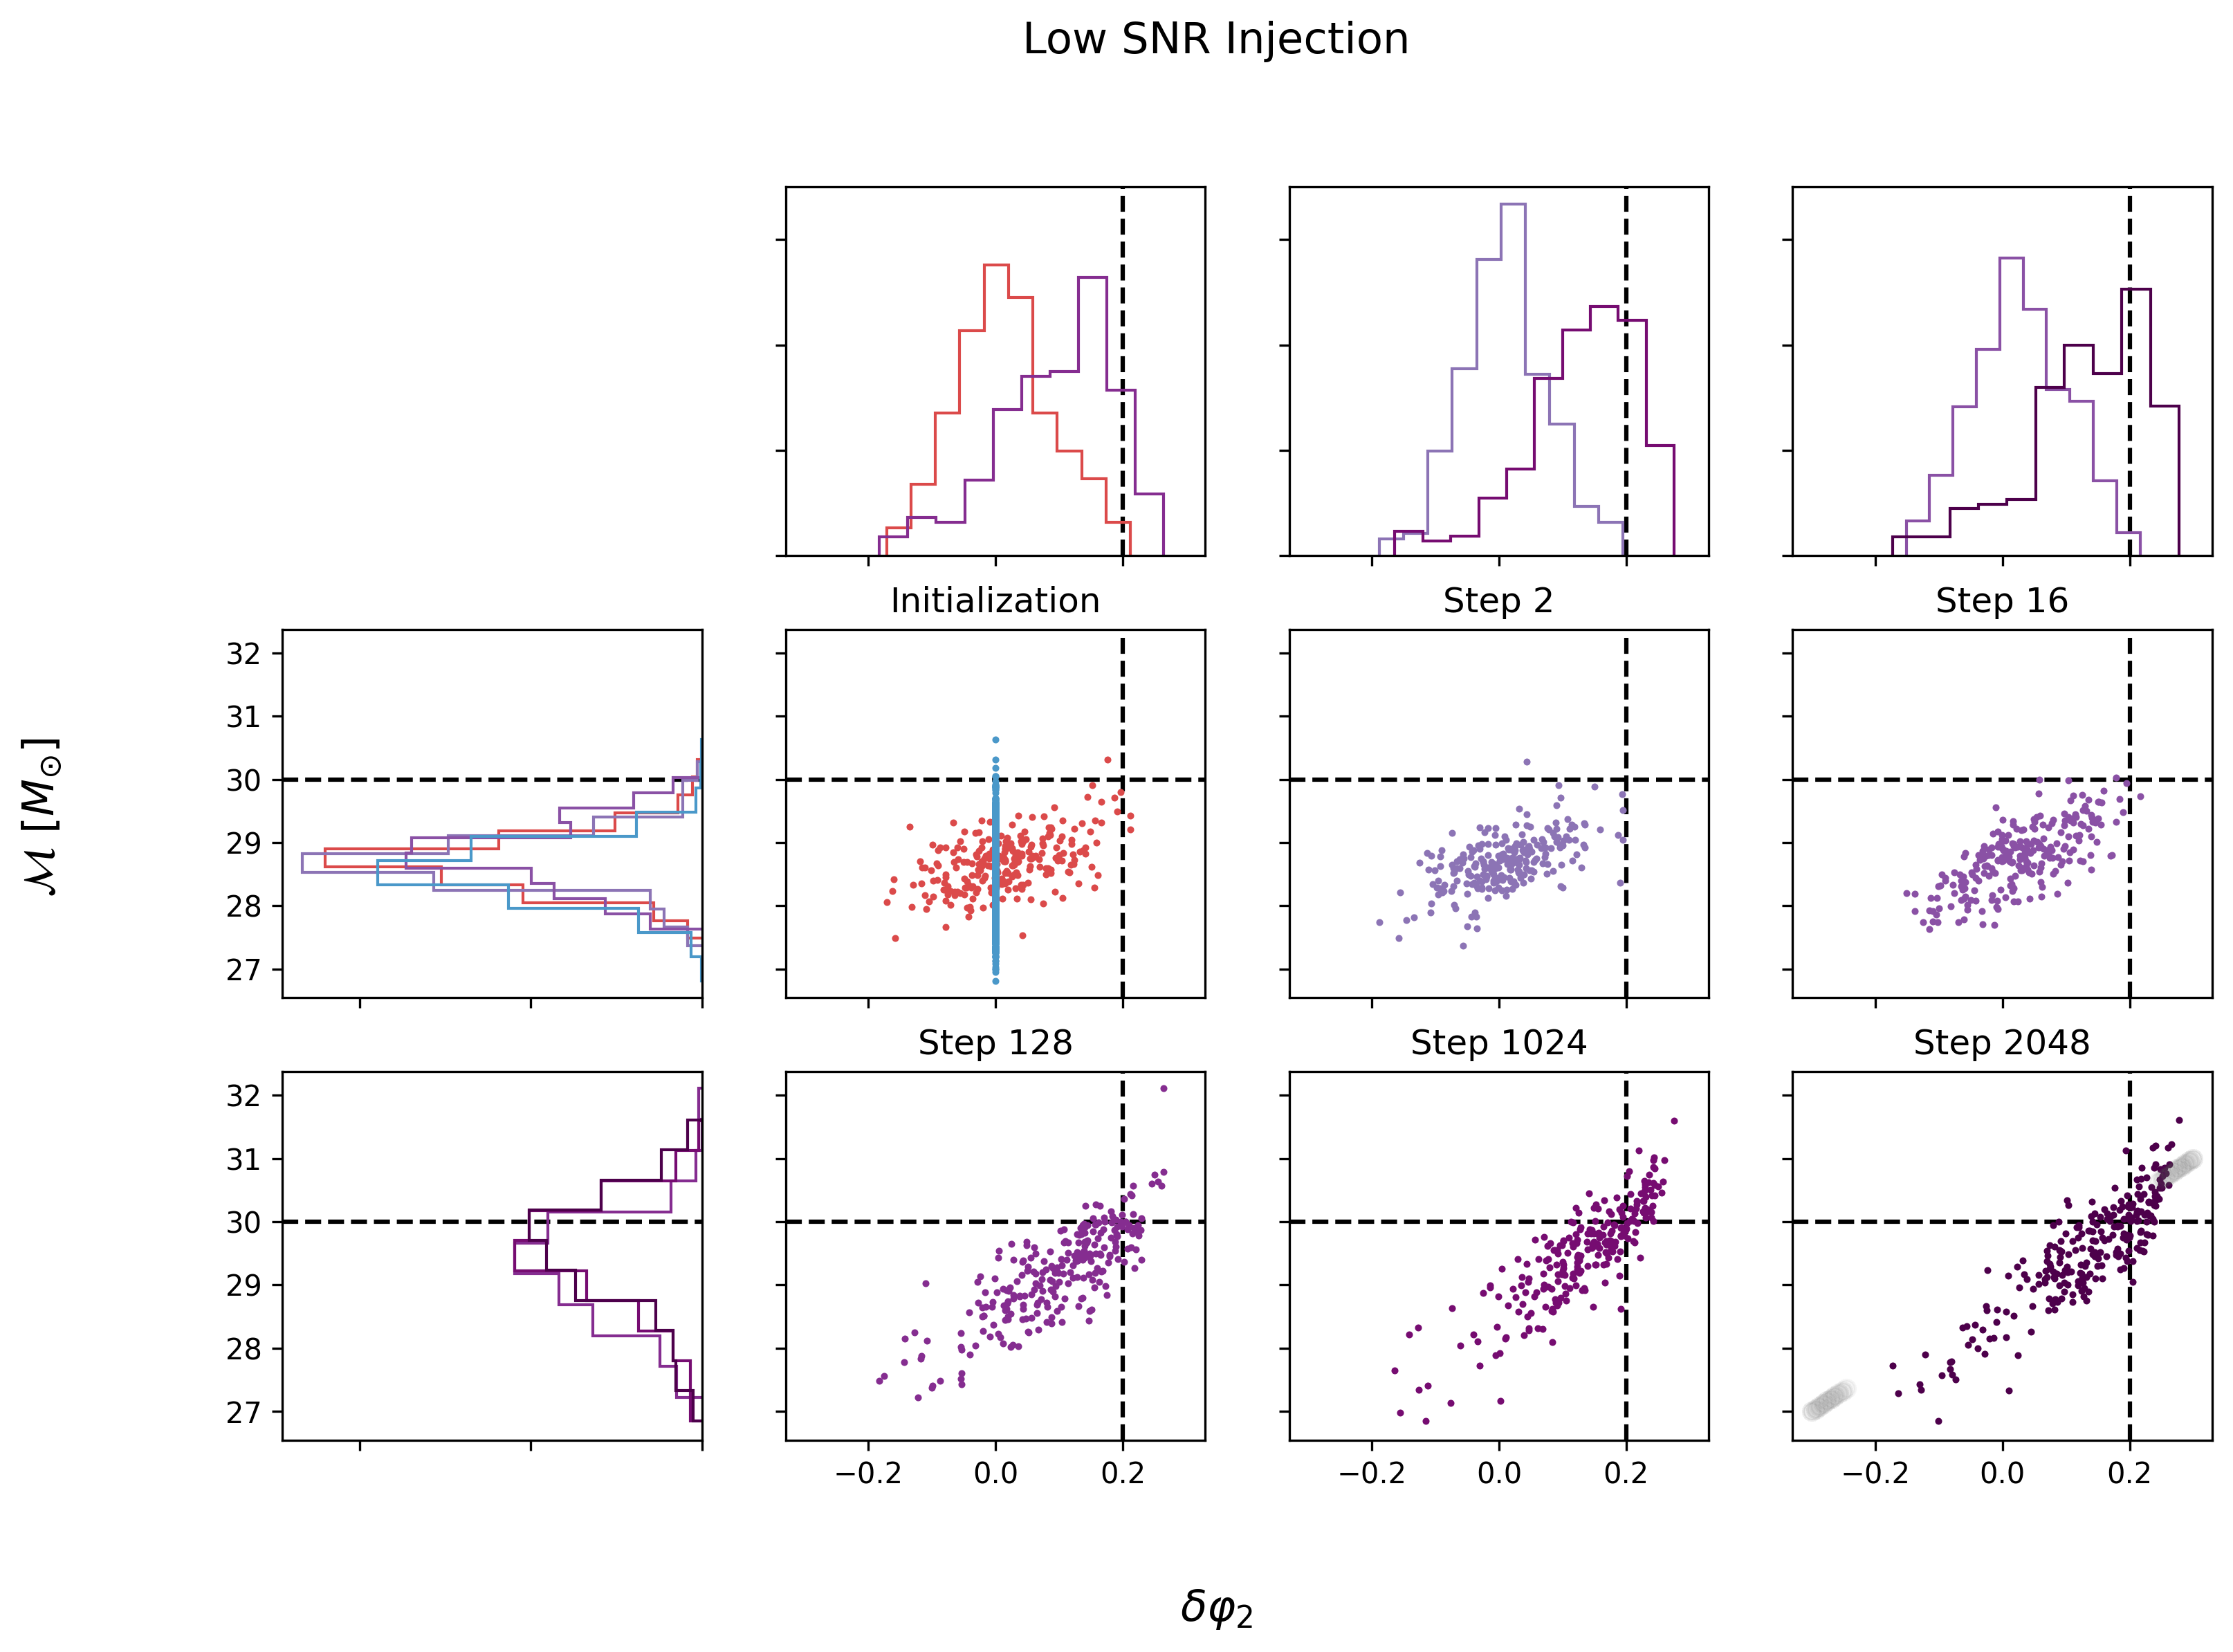

In [162]:
fig_low

In [126]:
nm = 20
nd = 50
test_dpi, test_ms = np.mgrid[ 
    0.2:0.3:nd*1j, 29:31:nm*1j  
]
overlaps = np.zeros((nd,nm))

for i in tqdm(range(nd)):
    for j in range(nm):
        x_inject = copy.deepcopy(inject)
        x_inject["chirp_mass"] = test_ms[i,j]
        x_inject["d_phi_2"]    = test_dpi[i,j]
        _, complex_overlap = waveform_generator.frequency_domain_strain(parameters=x_inject)
        overlaps[i,j] = abs(complex_overlap)

  0%|          | 0/50 [00:00<?, ?it/s]/home/noah.wolfe/.conda/envs/testing-gr/lib/python3.8/site-packages/pycbc/types/array.py:200: RuntimeWarning: invalid value encountered in true_divide
  ret = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


In [127]:
overlaps[ overlaps > 0.9 ] = np.nan
#overlaps[ overlaps <= 0.9 ] = 0.5

In [128]:
axes_low[-1,-1].scatter(
    test_dpi, test_ms, c=overlaps, cmap=plt.cm.Greys, zorder=-2
)

#axes_low[-1,-1].contourf(
#    test_dpi, test_ms,
#    overlaps, cmap=plt.cm.Greys, zorder=-2
#)
#axes_low[1,1].set_ylim(25,30)

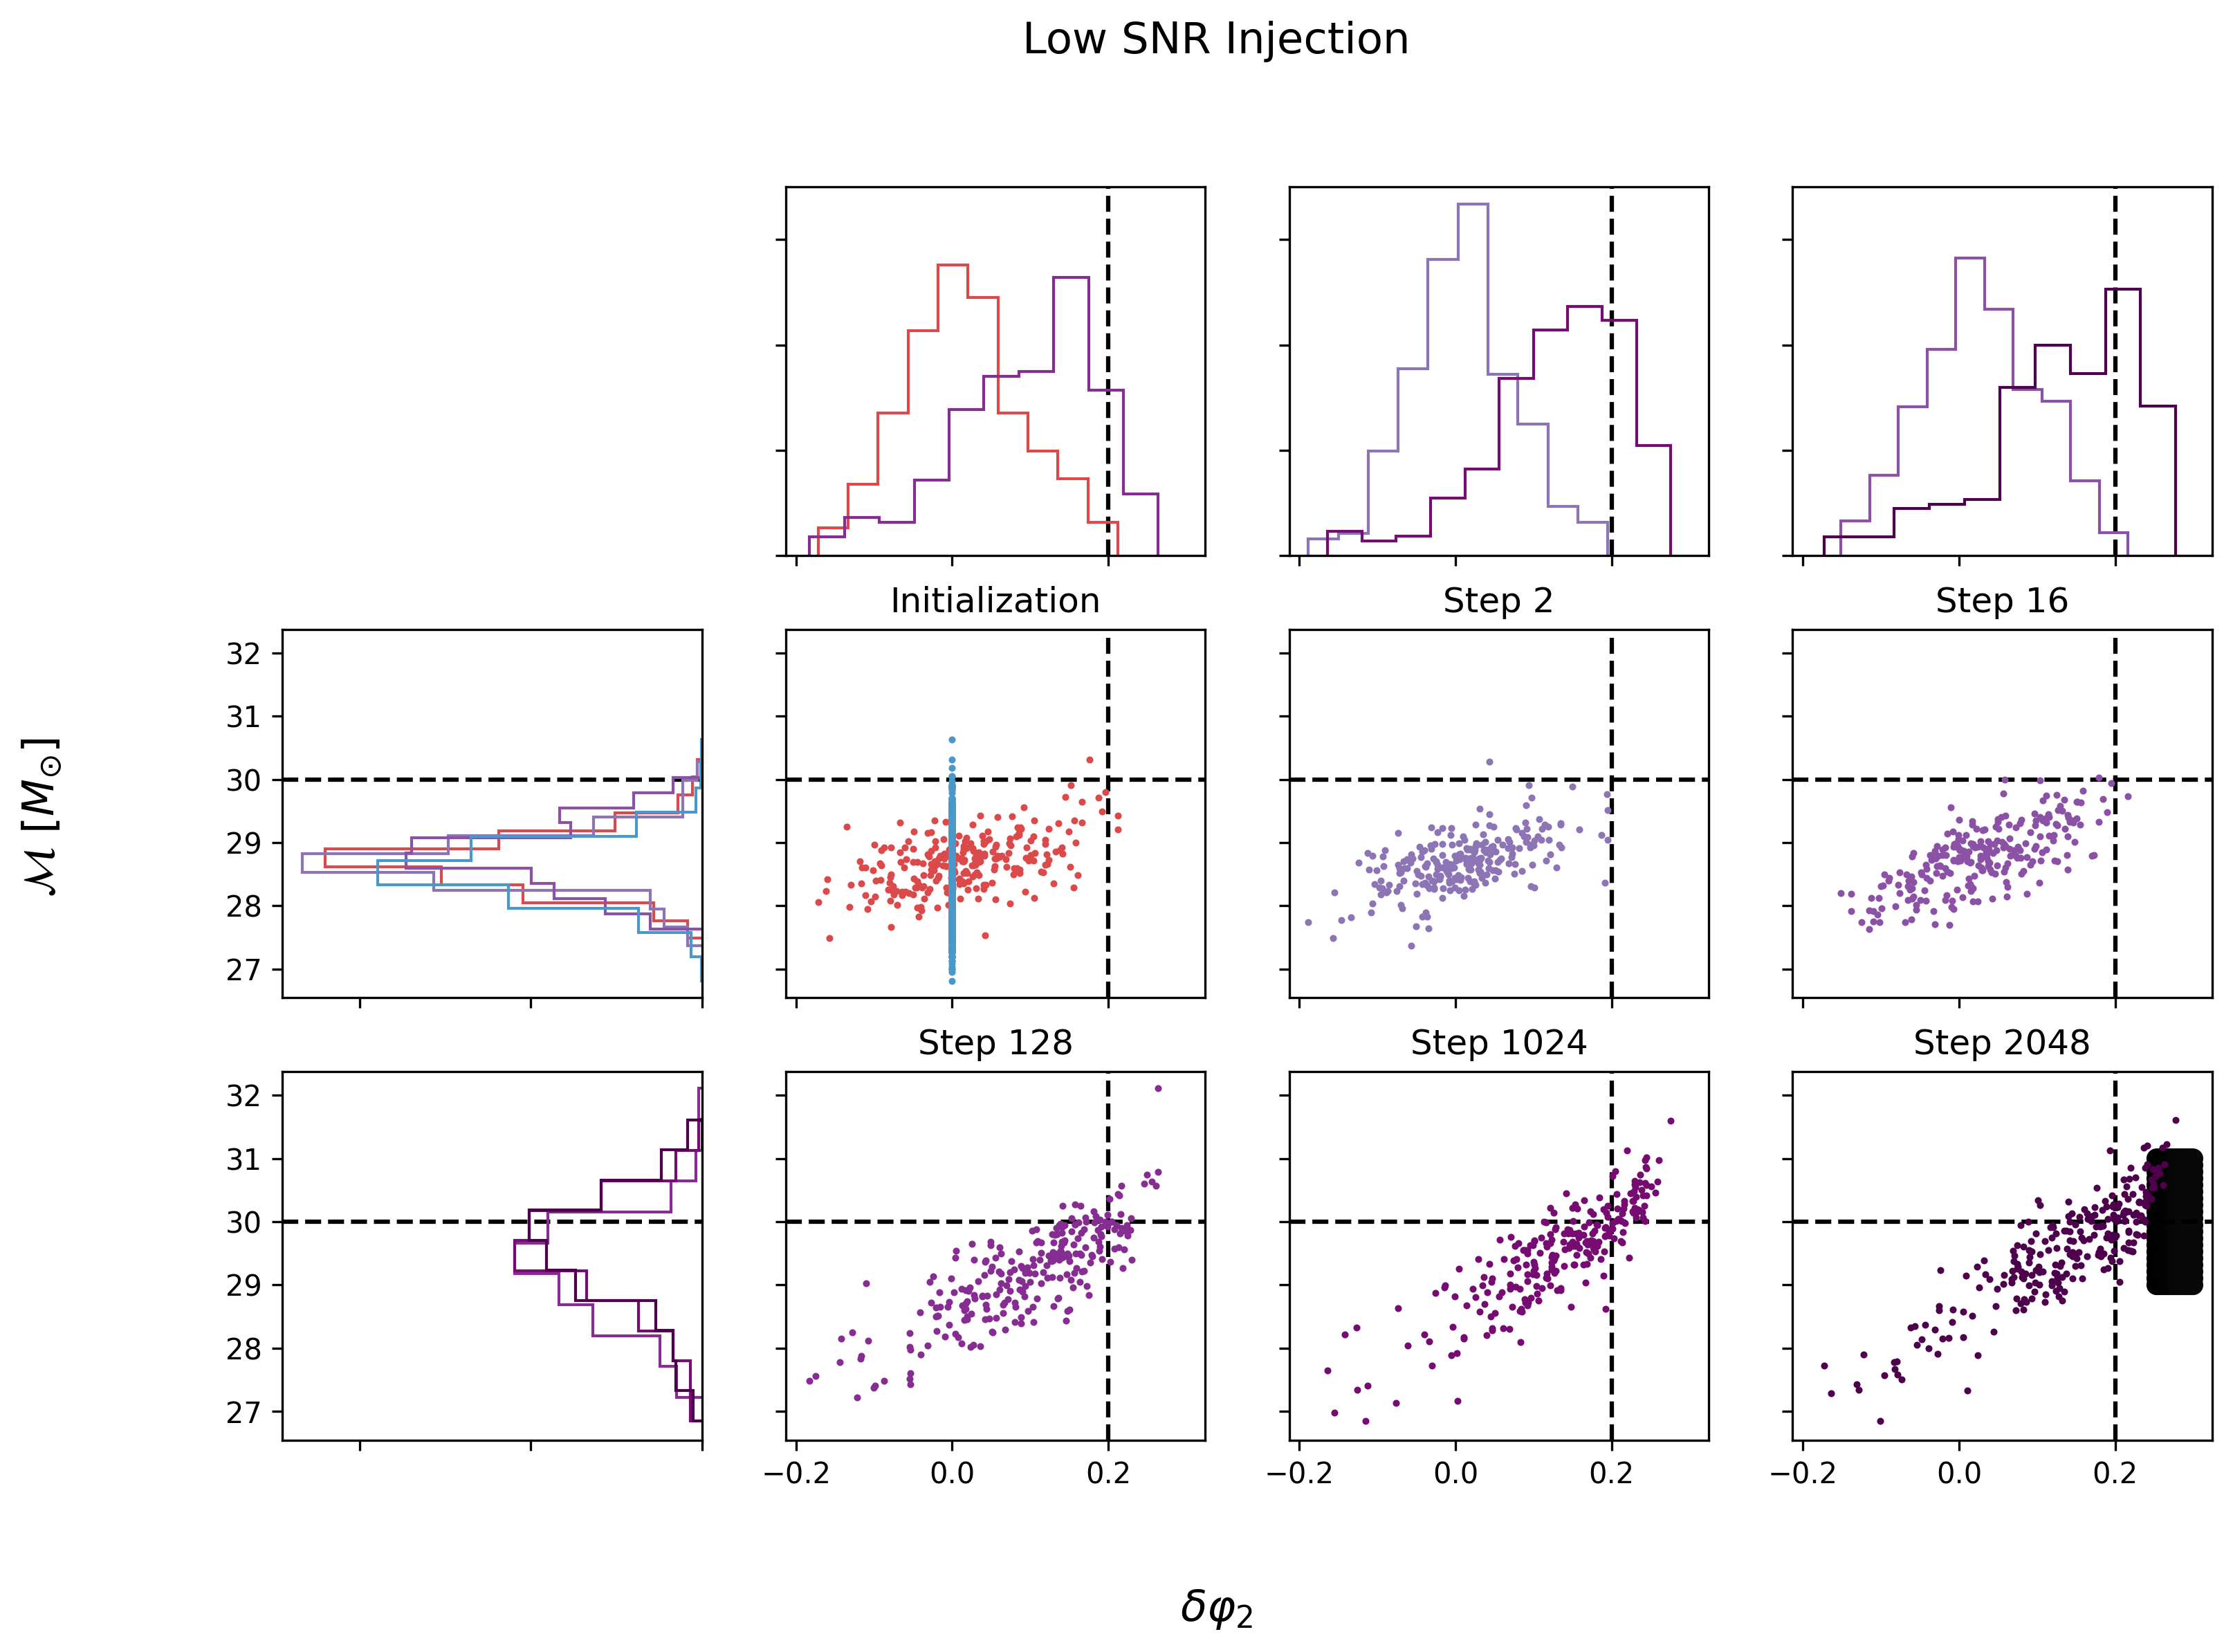

In [129]:
fig_low

In [108]:
overlaps.max()

0.9314799682013807

In [42]:
scipy.optimize.minimize(opt_func, [ inject["chirp_mass"], inject["d_phi_2"] ])

30.30677958954947 0.23266715146936673 0.9120559486561028
30.306779604450632 0.23266715146936673 0.9120559486561028
30.30677958954947 0.23266716637052792 0.9120559396864697
30.30677958954947 0.8346090424839427 0.7635167736042937
30.306779604450632 0.8346090424839427 0.7635167736042937
30.30677958954947 0.8346090573851039 0.763516771146168
30.30677958954947 0.3638464850818153 0.8400476362129633
30.306779604450632 0.3638464850818153 0.8400476362129633
30.30677958954947 0.36384649998297647 0.8400476296263644
30.30677958954947 0.25723260443339085 0.8972765109194623
30.306779604450632 0.25723260443339085 0.8972765109194623
30.30677958954947 0.25723261933455205 0.8972765019955228
30.30677958954947 0.24498124356379763 0.9046378774238291
30.306779604450632 0.24498124356379763 0.9046378774238291
30.30677958954947 0.24498125846495883 0.9046378684496857
30.30677958954947 0.25321025917778534 0.8996885481022019
30.306779604450632 0.25321025917778534 0.8996885481022019
30.30677958954947 0.25321027407

      fun: 4.474410397747874e-09
 hess_inv: array([[1.        , 0.        ],
       [0.        , 0.05543877]])
      jac: array([ 0.00000000e+00, -1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 2
     njev: 28
   status: 0
  success: True
        x: array([30.30677959,  0.25269157])

In [43]:
scipy.optimize.minimize(opt_func, [ 10, inject["d_phi_2"] ])

10.0 0.23266715146936673 0.9120559486561028
10.000000014901161 0.23266715146936673 0.9120559486561028
10.0 0.23266716637052792 0.9120559396864697
10.0 0.8346090424839427 0.7635167736042937
10.000000014901161 0.8346090424839427 0.7635167736042937
10.0 0.8346090573851039 0.763516771146168
10.0 0.3638464850818153 0.8400476362129633
10.000000014901161 0.3638464850818153 0.8400476362129633
10.0 0.36384649998297647 0.8400476296263644
10.0 0.25723260443339085 0.8972765109194623
10.000000014901161 0.25723260443339085 0.8972765109194623
10.0 0.25723261933455205 0.8972765019955228
10.0 0.24498124356379763 0.9046378774238291
10.000000014901161 0.24498124356379763 0.9046378774238291
10.0 0.24498125846495883 0.9046378684496857
10.0 0.25321025917778534 0.8996885481022019
10.000000014901161 0.25321025917778534 0.8996885481022019
10.0 0.25321027407894653 0.8996885391558518
10.0 0.2519309985116791 0.9004568480635788
10.000000014901161 0.2519309985116791 0.9004568480635788
10.0 0.2519310134128403 0.9004

      fun: 4.474410397747874e-09
 hess_inv: array([[1.        , 0.        ],
       [0.        , 0.05543877]])
      jac: array([ 0.00000000e+00, -1.49011612e-08])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 2
     njev: 28
   status: 0
  success: True
        x: array([10.        ,  0.25269157])

# GW150914

## Overlap cut

In [18]:
gw150914_rundir = "/home/noah.wolfe/MA499_report_runs/real/pure-gr/GW150914/hybrid_pure-gr_GW150914/"
gw150914_prefix =  "hybrid_pure-gr_GW150914_data0_1126259462-391_analysis_H1L1_dynesty"
gw_hybrid_result, gw_hybrid_resume = load_hybrid_data(
    gw150914_rundir, 
    gw150914_prefix,
    "d_phi_2"
)

In [19]:
gw_nest_result = load_nest_data(
    gw150914_rundir, 
    gw150914_prefix,
)

(<Figure size 3600x2400 with 12 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:title={'center':'Initialization'}>,
         <AxesSubplot:title={'center':'Step 2'}>,
         <AxesSubplot:title={'center':'Step 16'}>],
        [<AxesSubplot:>, <AxesSubplot:title={'center':'Step 128'}>,
         <AxesSubplot:title={'center':'Step 1024'}>,
         <AxesSubplot:title={'center':'Step 2048'}>]], dtype=object))

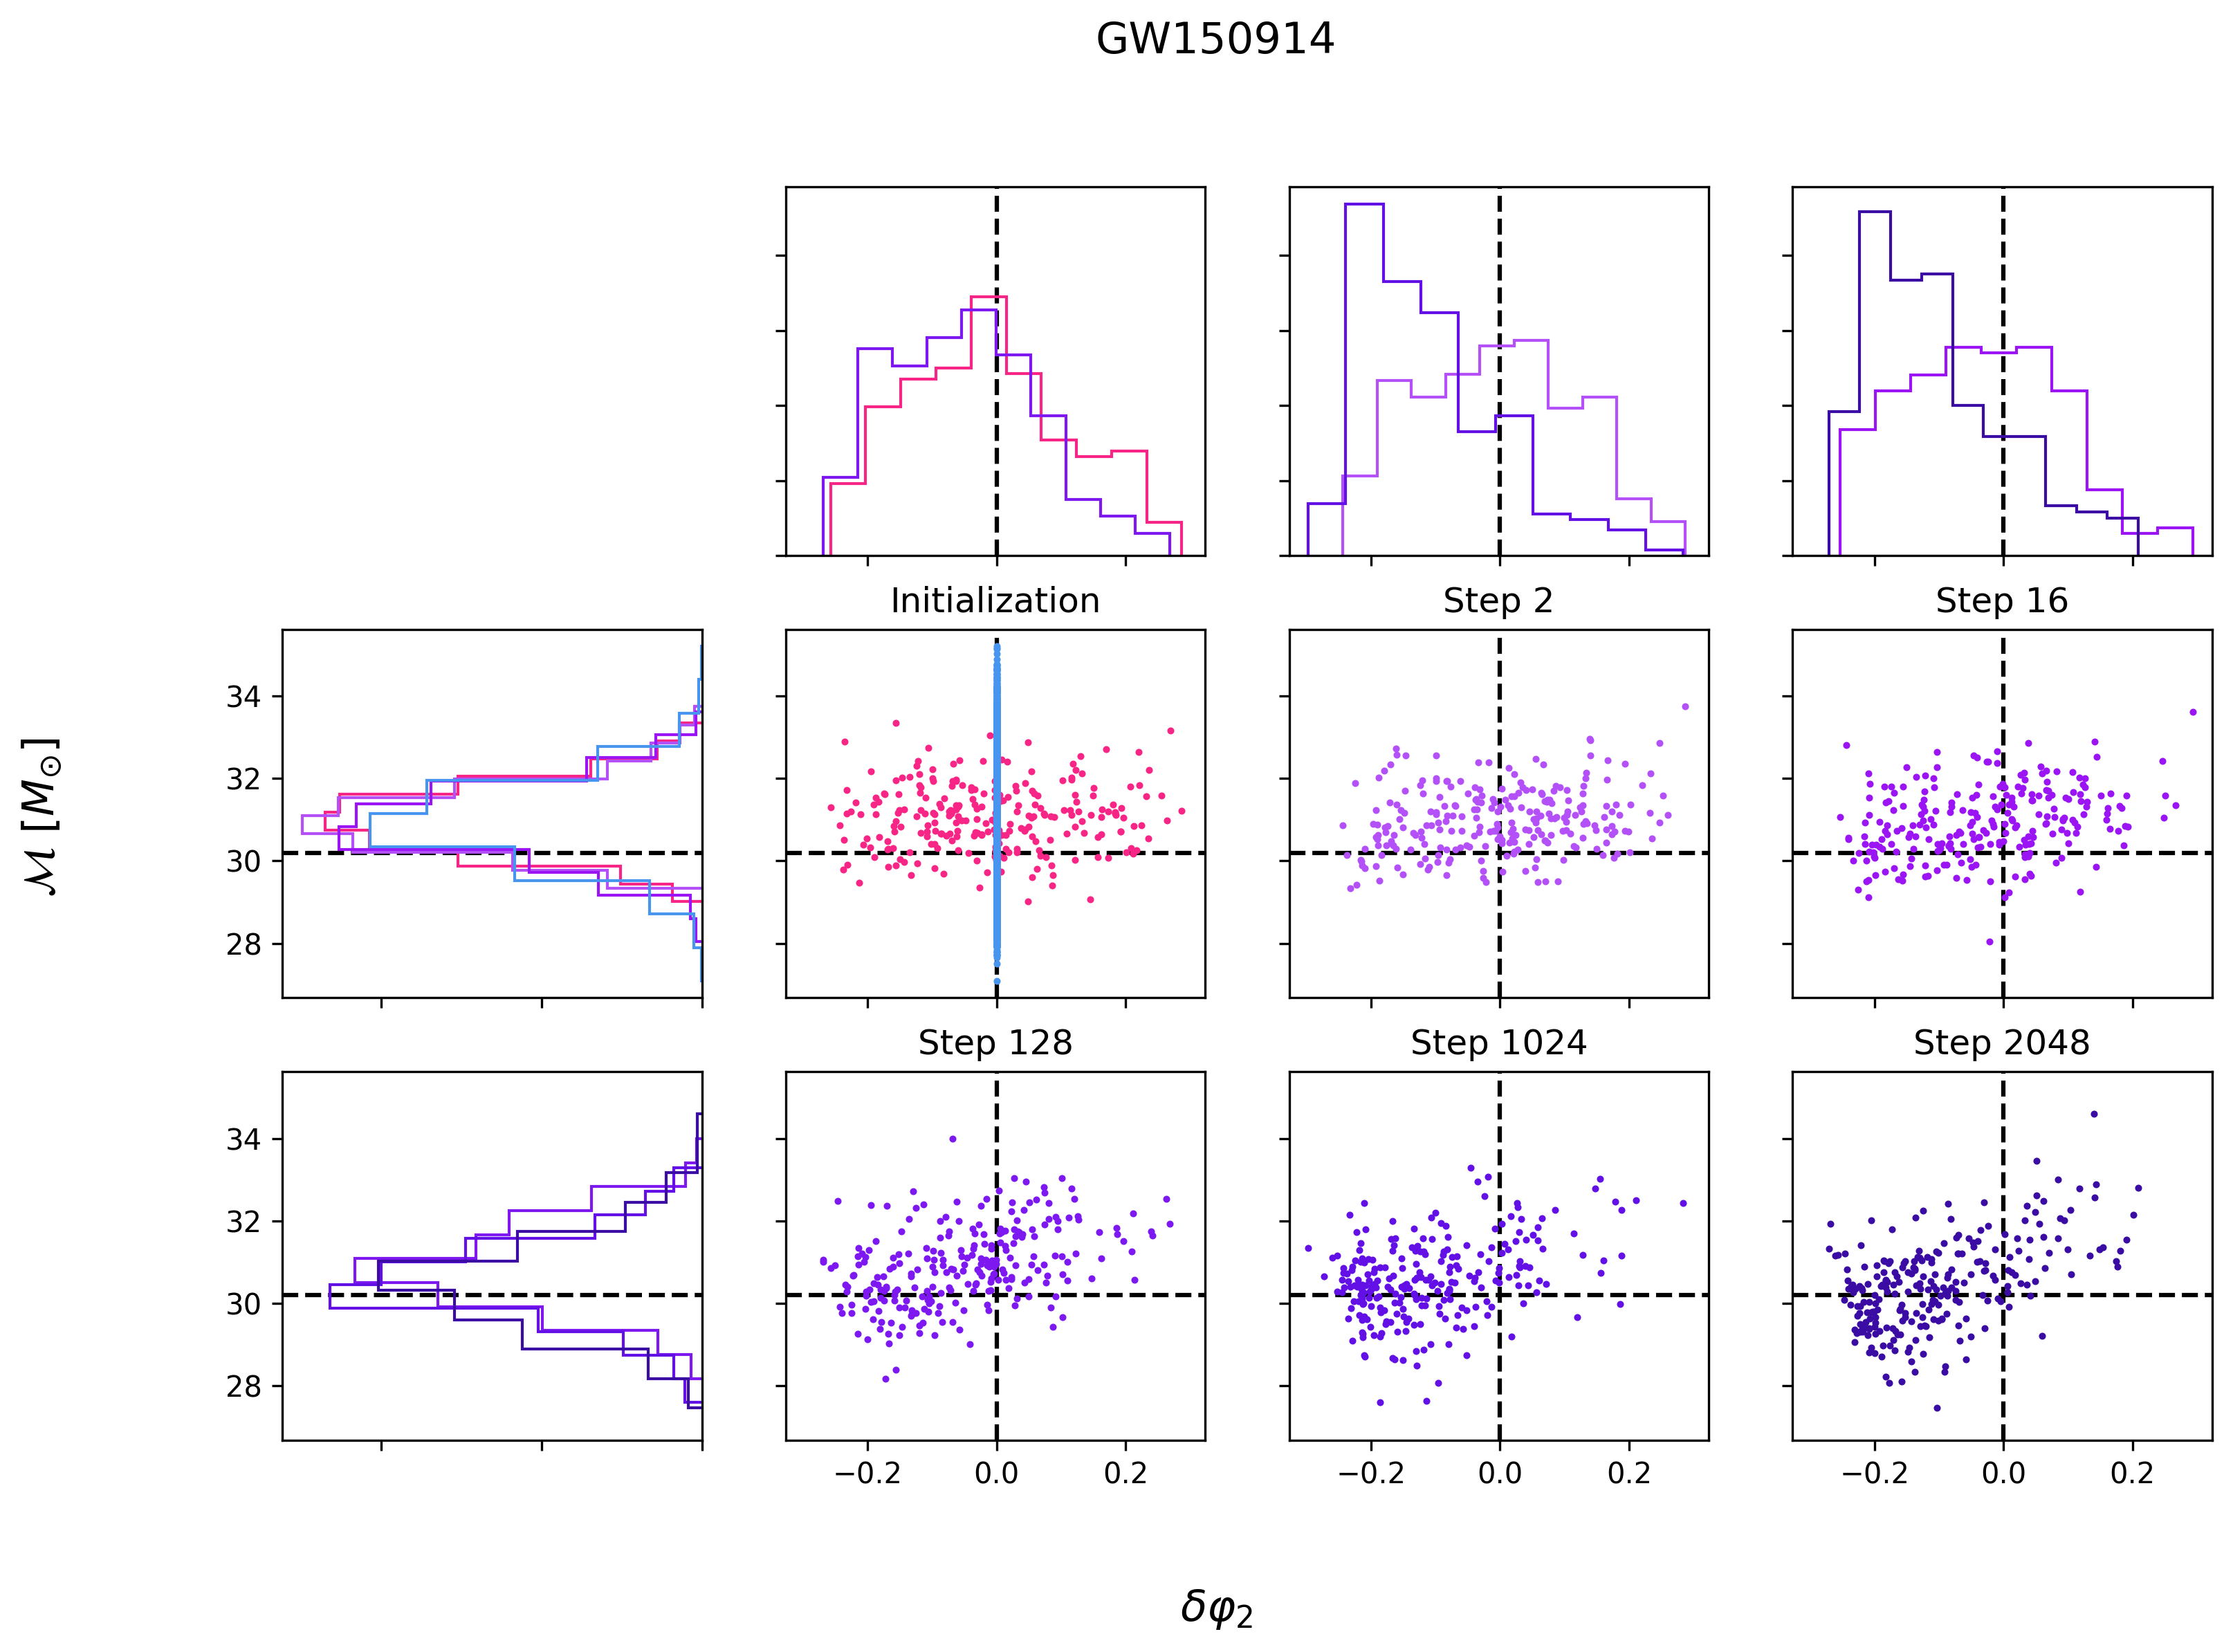

In [20]:
plot_evolution(
    gw_nest_result, gw_hybrid_result, gw_hybrid_resume, 
    "d_phi_2", "chirp_mass", r"$\delta \varphi_2$", "$\mathcal{M}$ [$M_{\odot}$]", 0, 30.2, "GW150914",
    plot_kde=False
)

## no overlap cut

In [ ]:
gw150914_rundir = "/home/noah.wolfe/MA499_report_runs/real/pure-gr/GW150914/hybrid_pure-gr_GW150914/"
gw150914_prefix =  "hybrid_pure-gr_GW150914_data0_1126259462-391_analysis_H1L1_dynesty"
gw_hybrid0_result, gw_hybrid0_resume = load_hybrid_data(
    gw150914_rundir, 
    gw150914_prefix,
    "d_phi_2",
    extra_label="no-overlap"
)

In [ ]:
plot_evolution(
    gw_nest_result, gw_hybrid0_result, gw_hybrid0_resume, 
    "d_phi_2", "chirp_mass", r"$\delta \varphi_2$", "$\mathcal{M}$ [$M_{\odot}$]", 0, 30.2, "GW150914 (No overlap)",
    plot_kde=False
)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(<Figure size 3600x2400 with 12 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:title={'center':'Initialization'}>,
         <AxesSubplot:title={'center':'Step 2'}>,
         <AxesSubplot:title={'center':'Step 16'}>],
        [<AxesSubplot:>, <AxesSubplot:title={'center':'Step 128'}>,
         <AxesSubplot:title={'center':'Step 1024'}>,
         <AxesSubplot:title={'center':'Step 2048'}>]], dtype=object))

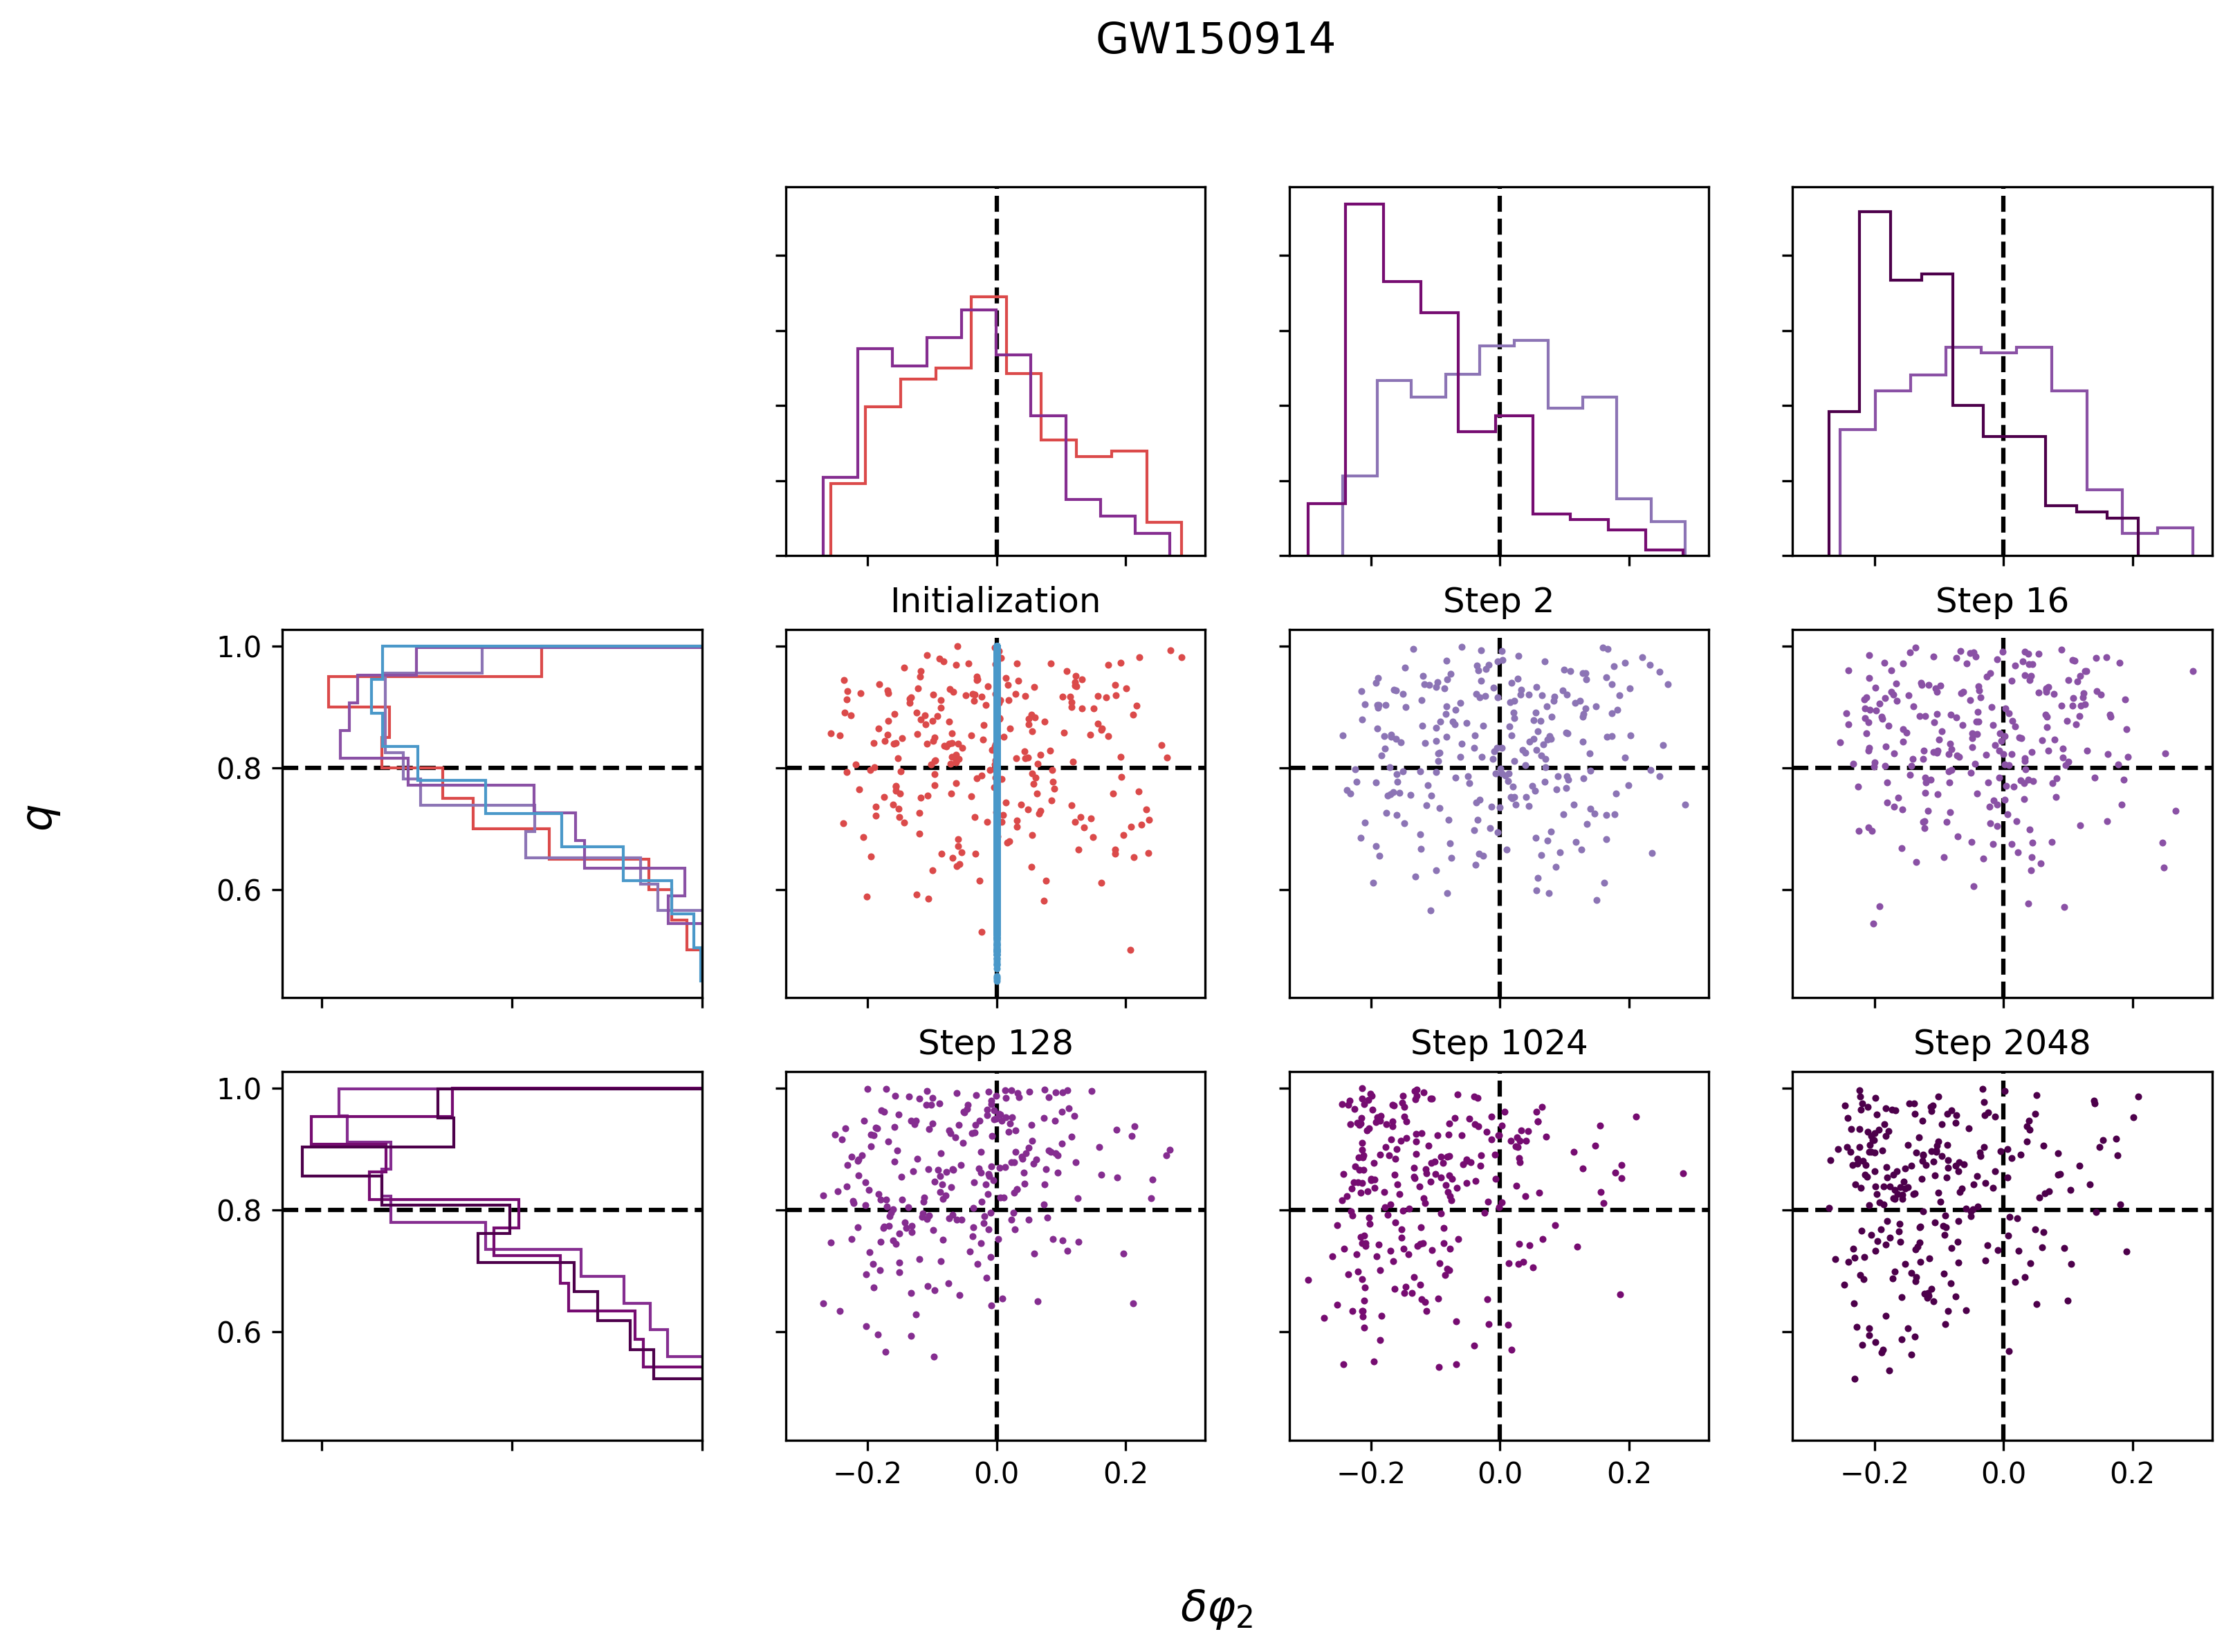

In [452]:
plot_evolution(
    gw_nest_result, gw_hybrid_result, gw_hybrid_resume, 
    "d_phi_2", "mass_ratio", r"$\delta \varphi_2$", "$q$", 0, 0.8, "GW150914",
    plot_kde=False
)

## no overlap cut

# OTher STuff?

In [18]:
rundir = "/home/noah.wolfe/MA499_report_runs/real/pure-gr/GW150914/hybrid_pure-gr_GW150914/"
resultdir = os.path.join(rundir, "result")

result_prefix = "hybrid_pure-gr_GW150914_data0_1126259462-391_analysis_H1L1_dynesty"

result_paths = [
    os.path.join(resultdir, "%s_%s_result.json" % (result_prefix, d))
    for d in dpi
]

resume_paths = [
    os.path.join(resultdir, "%s_%s_checkpoint_resume.pickle" % (result_prefix, d))
    for d in dpi
]

In [19]:
result_data = []
for p in tqdm(result_paths):
    if os.path.isfile(p):
        result_data.append(
            bilby.core.result.read_in_result(p)
        )
    else:
        result_data.append(None)

100%|██████████| 14/14 [02:49<00:00, 12.11s/it]


In [43]:
resume_data = []
for p in tqdm(resume_paths):
    if os.path.isfile(p):
        with open(p, "rb") as f:
            resume_data.append( dill.load(f) )
    else:
        result_data.append(None)

100%|██████████| 14/14 [00:54<00:00,  3.92s/it]


In [20]:
nest_result_path = os.path.join(
    resultdir,
    "%s_result.json" % result_prefix
)

nest_data = bilby.core.result.read_in_result(nest_result_path)

In [45]:
resume_data[2]["pos0"].shape

(5, 250, 54)

# New Code

In [ ]:
def plot_evolution(nest_result, hybrid_result, pos0, xparam, yparam, xlabel, ylabel, iterations = [0, 249, 499, 1999, 29999, 64999]):
    
    dpi_idx = hybrid_result.search_parameter_keys.index(xparam)
    m_hybrid_idx = hybrid_result.search_parameter_keys.index(yparam)
    m_nest_idx = nest_result.search_parameter_keys.index(yparam)
    
    nwalkers = hybrid_result.sampler_kwargs["nwalkers"]
    nnest, _, _ = nest_result.samples.shape
    
    fig, axes = plt.subplots(figsize=(12,8), dpi=100, sharex=True, sharey=True, nrows=2, ncols=3)
    fig.supxlabel(xlabel, fontsize=20)
    fig.supylabel(ylabel, fontsize=20)

    axes[0,0].scatter(
        np.zeros(nnest), nest_result.samples[:,m_nest_idx],
        s=4
    )

    axes[0,0].scatter(
        pos0[0,:,dpi_idx], pos0[0,:,m_hybrid_idx],
        s=4
    )

    for i,(ax,it) in tqdm(enumerate(zip(axes.flat,iterations))):
        if i == 0:
            continue

        x = result_data[2].samples[:it, dpi_idx]
        y = result_data[2].samples[:it, m_hybrid_idx]
        X, Y = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        values = np.vstack([x, y])
        kernel = scipy.stats.gaussian_kde(values)
        Z = np.reshape(kernel(positions).T, X.shape) 

        ax.contour(X, Y, Z, cmap=plt.cm.gist_earth_r)

        ax.scatter(
            hybrid_result.samples[ it:it+250, dpi_idx ], hybrid_result.samples[ it:it+250, m_hybrid_idx ],
            s=4
        )

        ax.set_title("Iteration %d" % (it + 1))
        
        ax.tick_params(labelsize=17.5)

In [ ]:
fig, axes = plt.subplots(figsize=(12,8), dpi=100, sharex=True, sharey=True, nrows=2, ncols=3)
fig.supxlabel(r"$\delta \varphi_2$", fontsize=20)
fig.supylabel(r"$\mathcal{M}$ [$M_{\odot}$]", fontsize=20)

axes[0,0].scatter(
    np.zeros(len(nest_data.samples)), nest_data.samples[:,m_nest_idx],
    s=4
)

axes[0,0].scatter(
    resume_data[2]["pos0"][0,:,dpi_idx], resume_data[2]["pos0"][0,:,m_hybrid_idx],
    s=4
)

its = [0, 249, 499, 1999, 29999, 64999]
for i,(ax,it) in tqdm(enumerate(zip(axes.flat,its))):
    if i == 0:
        continue

    x = result_data[2].samples[:it, dpi_idx]
    y = result_data[2].samples[:it, m_hybrid_idx]
    X, Y = np.mgrid[x.min():x.max():1000j, y.min():y.max():1000j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = scipy.stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape) 
    
    ax.contour(X, Y, Z, cmap=plt.cm.gist_earth_r)
          #extent=[x.min(), x.max(), y.min(), y.max()])
        
    ax.scatter(
        result_data[2].samples[ it:it+250, dpi_idx ], result_data[2].samples[ it:it+250, m_hybrid_idx ],
        s=4
    )
    
    ax.set_title("Iteration %d" % (it + 1))

4it [01:23, 23.29s/it]

2it [00:00, 19.18it/s]

-0.2837728999522853 28.204218185388292
-0.28538972831948956 27.825765897404395


3it [00:00, 10.94it/s]

-0.3162899356290275 27.74997982201949


4it [00:00,  3.87it/s]

-0.3477220126896413 26.816641757392986


5it [00:10,  2.11s/it]


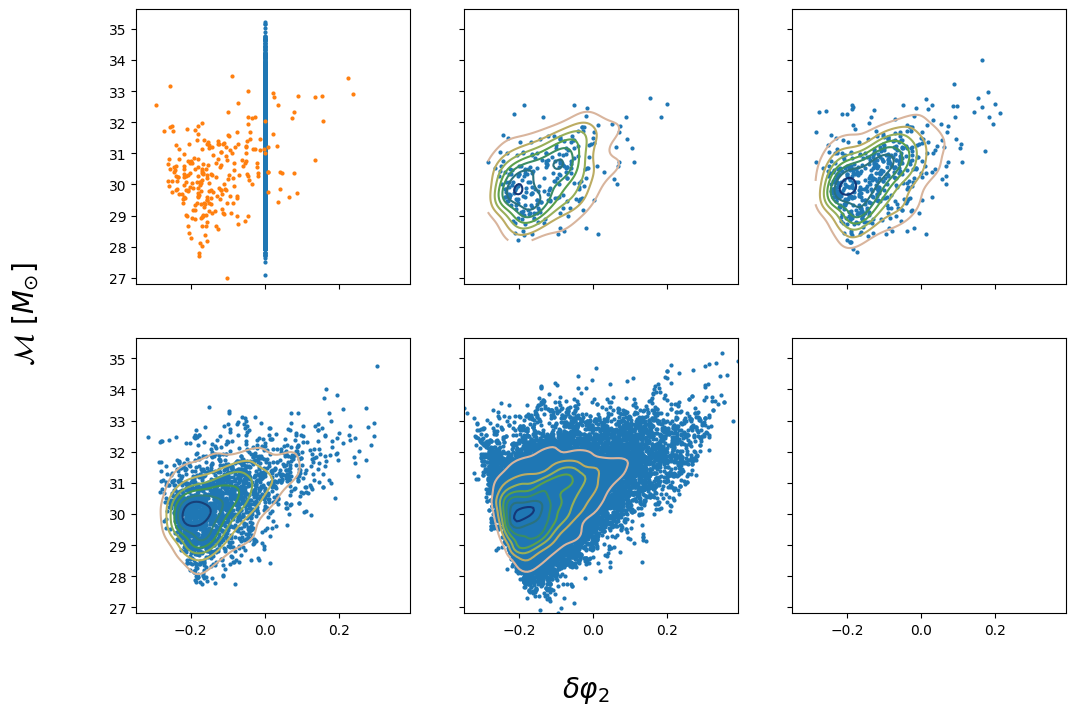

In [76]:
fig, axes = plt.subplots(figsize=(12,8), dpi=100, sharex=True, sharey=True, nrows=2, ncols=3)
fig.supxlabel(r"$\delta \varphi_2$", fontsize=20)
fig.supylabel(r"$\mathcal{M}$ [$M_{\odot}$]", fontsize=20)

axes[0,0].scatter(
    np.zeros(len(nest_data.samples)), nest_data.samples[:,m_nest_idx],
    s=4
)

axes[0,0].scatter(
    resume_data[2]["pos0"][0,:,dpi_idx], resume_data[2]["pos0"][0,:,m_hybrid_idx],
    s=4
)

its = [0, 249, 499, 1999, 29999]
for i,(ax,it) in tqdm(enumerate(zip(axes.flat,its))):
    if i == 0:
        continue

    x = result_data[2].samples[:it, dpi_idx]
    y = result_data[2].samples[:it, m_hybrid_idx]
    print(x.min(), y.min())
    X, Y = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = scipy.stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape) 
    
    ax.contour(X, Y, Z, cmap=plt.cm.gist_earth_r)
          #extent=[x.min(), x.max(), y.min(), y.max()])
        
    ax.scatter(
        result_data[2].samples[ :it, dpi_idx ], result_data[2].samples[ :it, m_hybrid_idx ],
        s=4
    )

# Old Code

In [2]:
def plot_evolution(nest_samples, pos0_x, pos0_y, x_samples, y_samples, steps, xlabel, ylabel, size=1, nrows=2, ncols=3, true_x=None, true_y=None):
    n_nest = len(nest_samples)
    
    fig, axes = plt.subplots(figsize=(12,8), nrows=nrows,ncols=ncols, sharex=True, sharey=True, dpi=100)
    fig.supxlabel(xlabel, fontsize=20)
    fig.supylabel(ylabel, fontsize=20)

    for (s,ax) in zip(steps,axes.flat):
        if s == -1: # from dynesty
            ax.set_title("Dynesty Posterior")
            ax.scatter( nest_samples, np.zeros(n_nest), s = size )
        elif s == 0:
            ax.scatter( nest_samples, np.zeros(n_nest) )
            ax.scatter( pos0_x, pos0_y )
            ax.set_title("pos0")
        else:
            ax.scatter(x_samples[:s], y_samples[:s], s = size)
            ax.set_title("Iteration %d" % (s + 1))
            
        if true_x is not None:
            ax.axvline(x=true_x,color="C1")
        if true_y is not None:
            ax.axhline(y=true_y,color="C1")
    
    plt.tight_layout()

In [3]:
rundir = "/home/noah.wolfe/MA499_report_runs/injected/beyond-gr/SNR/high/hybrid_beyond-gr_d_phi_2_dL100"
resultdir = os.path.join(rundir, "result")
hybrid_result_path = os.path.join(resultdir, "hybrid_beyond-gr_d_phi_2_dL100_data0_0_analysis_H1L1_dynesty_d_phi_2_result.json")
nest_result_path = os.path.join(resultdir, "hybrid_beyond-gr_d_phi_2_dL100_data0_0_analysis_H1L1_dynesty_result.json")

In [4]:
hybrid_result = bilby.core.result.read_in_result(hybrid_result_path)

In [5]:
nest_result = bilby.core.result.read_in_result(nest_result_path)

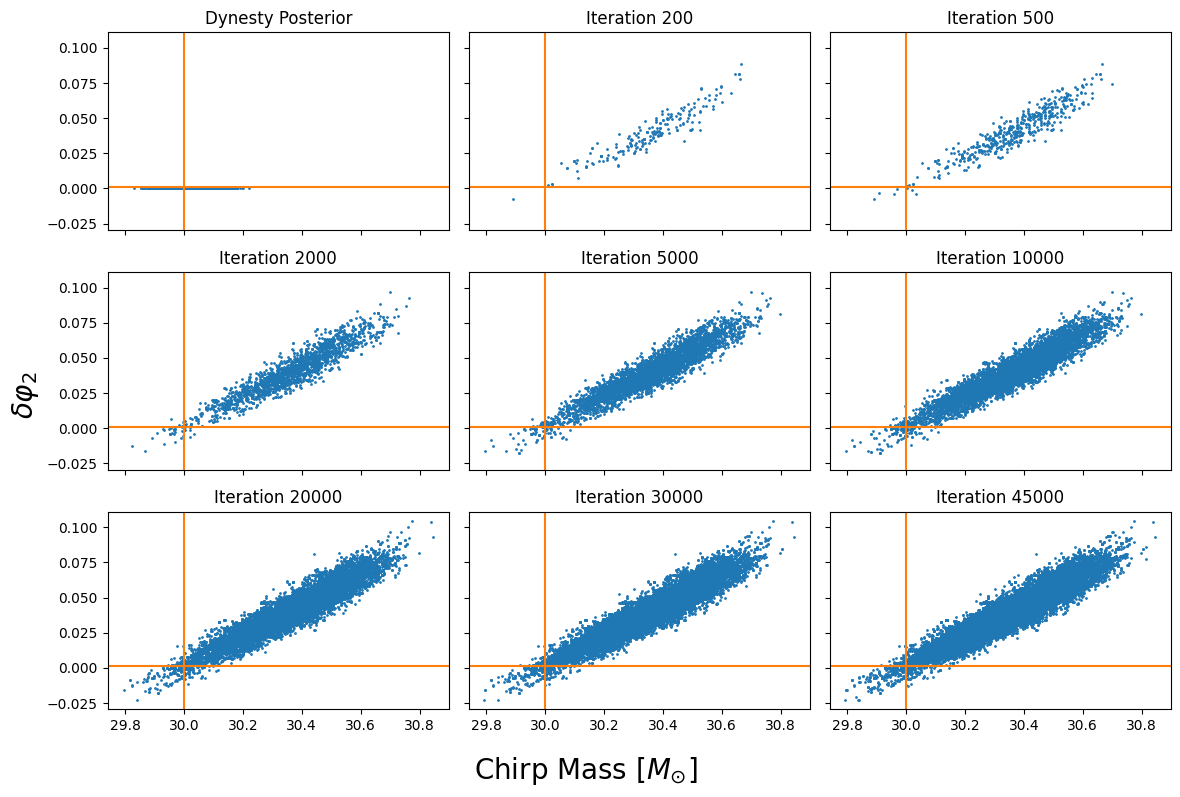

In [29]:
plot_evolution(
    nest_result.samples[:,0],
    None,#hybrid_result.pos0[0,:,0], # chirp mass
    None,#hybrid_result.pos0[0,:,10], # d_phi_2
    hybrid_result.samples[:,0], # chirp mass
    hybrid_result.samples[:,10], # d_phi_2
    [-1, 199, 499, 1999, 4999, 9999, 19999, 29999, 44999],
    r"Chirp Mass [$M_{\odot}$]",
    r"$\delta \varphi_2$",
    nrows=3,
    true_x=30,
    true_y=1E-3
)

In [6]:
def plot_evolution_not_cumulative(nest_samples, pos0_x, pos0_y, x_samples, y_samples, steps, xlabel, ylabel, size=1, nrows=2, ncols=3, true_x=None, true_y=None):
    n_nest = len(nest_samples)
    
    fig, axes = plt.subplots(figsize=(12,8), nrows=nrows,ncols=ncols, sharex=True, sharey=True, dpi=100)
    fig.supxlabel(xlabel, fontsize=20)
    fig.supylabel(ylabel, fontsize=20)

    for (s,ax) in zip(steps,axes.flat):
        if s == -1: # from dynesty
            ax.set_title("Dynesty Posterior")
            ax.scatter( nest_samples, np.zeros(n_nest), s = size )
        elif s == 0:
            ax.scatter( nest_samples, np.zeros(n_nest) )
            ax.scatter( pos0_x, pos0_y )
            ax.set_title("pos0")
        else:
            ax.scatter(x_samples[s:s+250], y_samples[s:s+250], s = size)
            ax.set_title("Iteration %d" % (s + 1))
            
        if true_x is not None:
            ax.axvline(x=true_x,color="C1")
        if true_y is not None:
            ax.axhline(y=true_y,color="C1")
    
    plt.tight_layout()

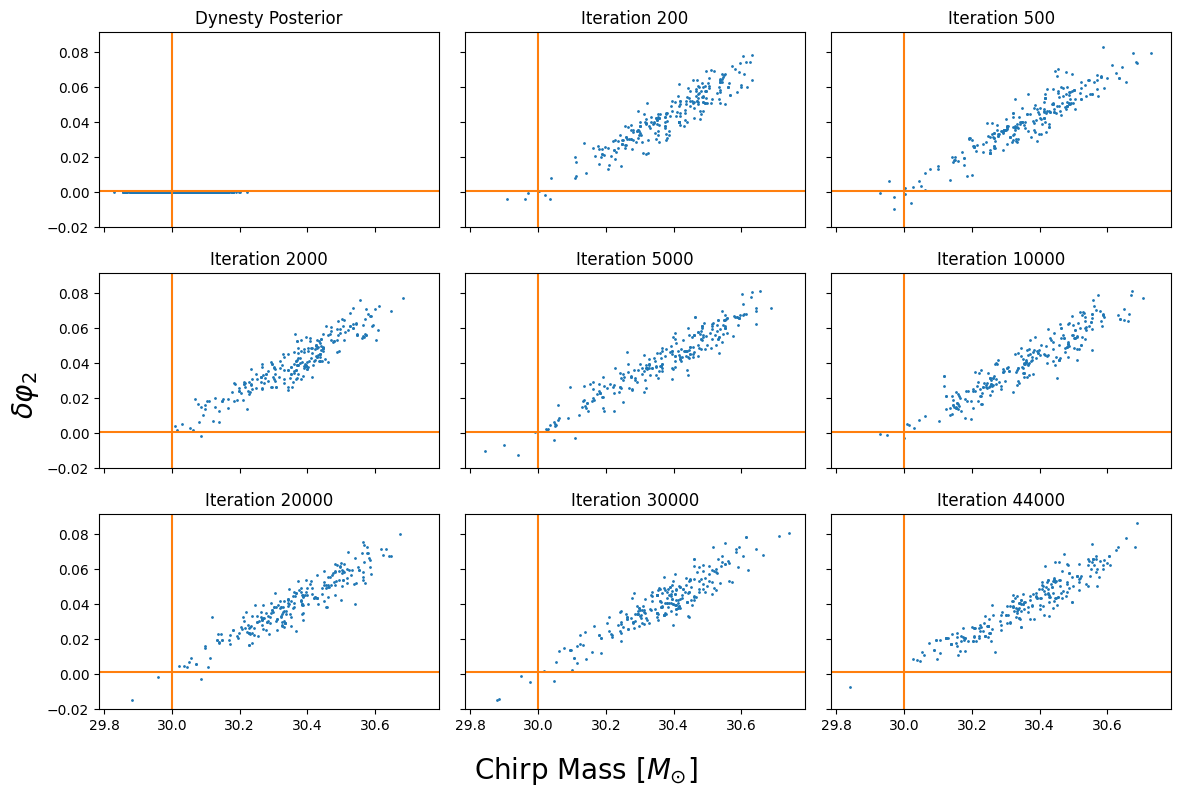

In [8]:
plot_evolution_not_cumulative(
    nest_result.samples[:,0],
    None,#hybrid_result.pos0[0,:,0], # chirp mass
    None,#hybrid_result.pos0[0,:,10], # d_phi_2
    hybrid_result.samples[:,0], # chirp mass
    hybrid_result.samples[:,10], # d_phi_2
    [-1, 199, 499, 1999, 4999, 9999, 19999, 29999, 43999],
    r"Chirp Mass [$M_{\odot}$]",
    r"$\delta \varphi_2$",
    nrows=3,
    true_x=30,
    true_y=1E-3
)

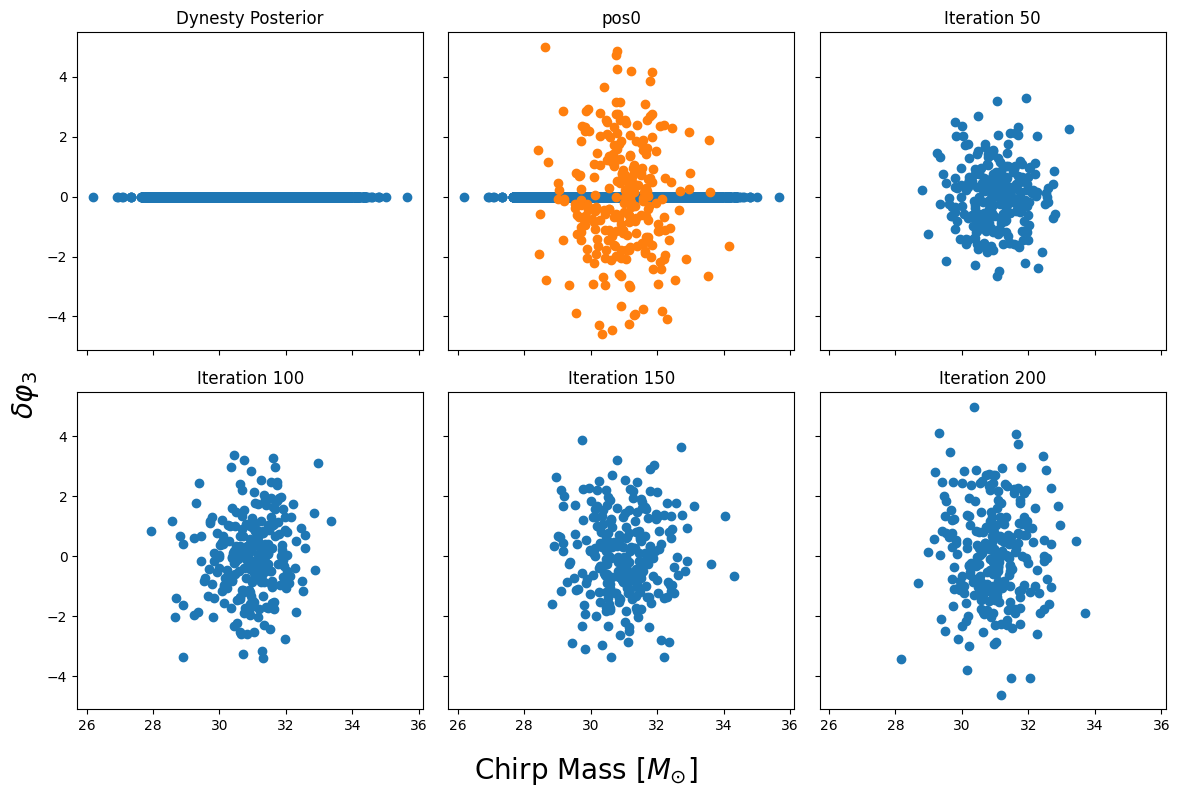

In [77]:
data = resume_data[0]
n_nest = nest_data.samples.shape[0]

fig, axes = plt.subplots(figsize=(12,8), nrows=2,ncols=3, sharex=True, sharey=True, dpi=100)
fig.supxlabel(r"Chirp Mass [$M_{\odot}$]", fontsize=20)
fig.supylabel(r"$\delta \varphi_3$", fontsize=20)

steps = [-1, 0, 49, 99, 149, 199]
for (s,ax) in zip(steps,axes.flat):
    if s == -1: # from dynesty
        ax.set_title("Dynesty Posterior")
        ax.scatter( nest_data.samples[:,0], np.zeros(n_nest) )
    elif s == 0:
        m_pos0 = data["pos0"][0,:,0]
        dpi_pos0 = data["pos0"][0,:,-1]
        ax.scatter( nest_data.samples[:,0], np.zeros(n_nest) )
        ax.scatter( m_pos0, dpi_pos0 )
        ax.set_title("pos0")
    else:
        step_dpi = data["chain_array"][:,s,-1]
        step_chirp_mass = data["chain_array"][:,s,0]

        ax.scatter(step_chirp_mass, step_dpi)
        ax.set_title("Iteration %d" % (s + 1))
    
plt.tight_layout()

In [41]:
datasupxlabel(r"Chirp Mass [$M_{\odot}$]", fontsize=20)
fig.supylabel(r"$\delta \varphi_3$", fontsize=20)

Text(0.02, 0.5, '$\\delta \\varphi_3$')

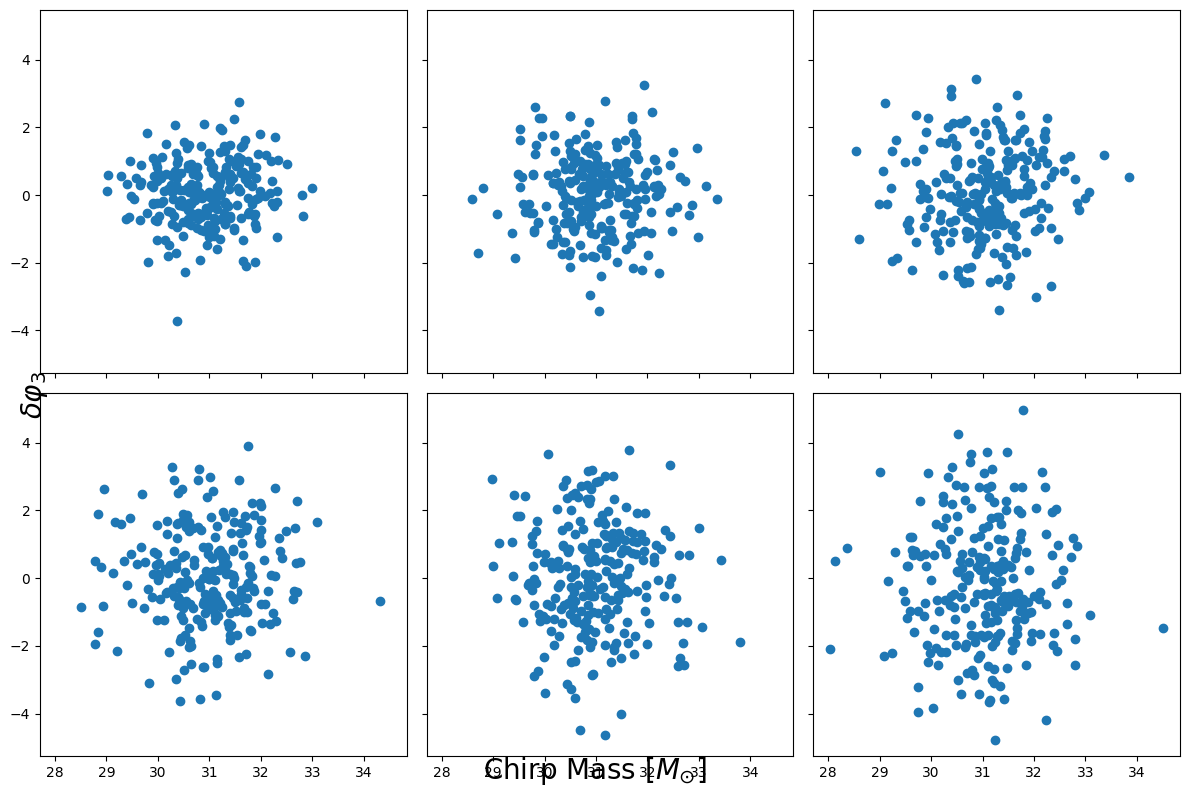

<Figure size 432x288 with 0 Axes>

In [43]:
plt.tight_layout()
fig

In [50]:
np.arange(10,300,20)

array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290])

In [ ]:
[0, 50, 100, 150, 200]

In [52]:
data["chain_array"][:,0,-1]

array([ 1.22116887e-01, -3.36041385e-01,  5.99873315e-01,  1.05710044e-01,
       -7.19305860e-01,  7.55344343e-02,  1.81569820e+00,  6.65767315e-01,
       -1.05389844e+00,  1.32707919e-01,  1.25277627e+00,  8.18192671e-01,
       -1.58560605e+00,  1.47113251e+00, -4.96458498e-01,  5.56549950e-01,
       -2.50011904e-01, -1.76640196e-01,  5.62344922e-01, -1.97882371e+00,
        1.44958230e+00, -6.27783836e-01,  6.18495623e-01, -1.52675648e-02,
       -6.52684988e-01,  9.06688011e-01, -8.51754218e-01, -2.12994776e-01,
       -8.49939944e-01,  1.90940441e-01,  1.70924541e-01,  1.96925287e-01,
       -6.10498713e-01,  1.30490035e+00,  8.17049506e-01,  3.83406767e-02,
        1.83203818e+00,  1.10175367e-01, -1.46242534e+00,  6.41589121e-01,
       -1.81334774e+00,  6.56677203e-01,  4.91652032e-01,  2.96896604e-01,
        8.21926266e-01, -1.72317094e+00, -2.16474411e-01, -1.00456470e+00,
        8.90269112e-01,  3.80511844e-01,  7.87014250e-01, -2.14967645e-01,
        1.50543335e+00, -